# Import Data

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud

from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor

import statsmodels.api as sm
from pylab import *
homestay = pd.read_csv(r'D:\硕士\2023-2024 S2\COMP7103 Data mining\Project\AB_NYC_2019.csv')

In [2]:
homestay.head()

id                                              name  host_id  \
0  2539                Clean & quiet apt home by the park     2787   
1  2595                             Skylit Midtown Castle     2845   
2  3647               THE VILLAGE OF HARLEM....NEW YORK !     4632   
3  3831                   Cozy Entire Floor of Brownstone     4869   
4  5022  Entire Apt: Spacious Studio/Loft by central park     7192   

     host_name neighbourhood_group neighbourhood  latitude  longitude  \
0         John            Brooklyn    Kensington  40.64749  -73.97237   
1     Jennifer           Manhattan       Midtown  40.75362  -73.98377   
2    Elisabeth           Manhattan        Harlem  40.80902  -73.94190   
3  LisaRoxanne            Brooklyn  Clinton Hill  40.68514  -73.95976   
4        Laura           Manhattan   East Harlem  40.79851  -73.94399   

         room_type  price  minimum_nights  number_of_reviews last_review  \
0     Private room    149               1                  9  2018-10-19   
1  Entire home/apt    225               1                 45  2019-05-21   
2     Private room    150               3                  0         NaN   
3  Entire home/apt     89               1                270  2019-07-05   
4  Entire home/apt     80              10                  9  2018-11-19   

   reviews_per_month  calculated_host_listings_count  availability_365  
0               0.21                               6               365  
1               0.38                               2               355  
2                NaN                               1               365  
3               4.64                               1               194  
4               0.10                               1                 0

In [3]:
len(homestay) # check amount of rows

48895

# I. Data Preprocessing

## 1. Deleting redundant columns

In [4]:
homestay.dtypes # check types of the columns

id                                  int64
name                               object
host_id                             int64
host_name                          object
neighbourhood_group                object
neighbourhood                      object
latitude                          float64
longitude                         float64
room_type                          object
price                               int64
minimum_nights                      int64
number_of_reviews                   int64
last_review                        object
reviews_per_month                 float64
calculated_host_listings_count      int64
availability_365                    int64
dtype: object

In [5]:
homestay.drop(['id','host_name','last_review'], axis=1, inplace=True) # Drop the 'host_name' not only because it is insignificant for analysis but also for ethical reasons. 

## 2. Data cleaning

### Missing values

In [6]:
homestay.isnull().sum()# check missing values

name                                 16
host_id                               0
neighbourhood_group                   0
neighbourhood                         0
latitude                              0
longitude                             0
room_type                             0
price                                 0
minimum_nights                        0
number_of_reviews                     0
reviews_per_month                 10052
calculated_host_listings_count        0
availability_365                      0
dtype: int64

In [7]:
homestay.fillna({'reviews_per_month':0},inplace=True) # If there were no reviews for the listing, review_per_month"  simply will not exist. So, we can simply append it with 0.0 for missing values.
homestay.isnull().sum() # recheck missing values

name                              16
host_id                            0
neighbourhood_group                0
neighbourhood                      0
latitude                           0
longitude                          0
room_type                          0
price                              0
minimum_nights                     0
number_of_reviews                  0
reviews_per_month                  0
calculated_host_listings_count     0
availability_365                   0
dtype: int64

### Checking duplicates

In [8]:
homestay.duplicated().sum()

0

## 3. Feature engineering

In [9]:
homestay["price"].describe() 
# The numerical distribution of the price reveals a mean value of 153.1. However, the price range extends from 0 to 10000, indicating the presence of some outliers.

count    48895.000000
mean       152.720687
std        240.154170
min          0.000000
25%         69.000000
50%        106.000000
75%        175.000000
max      10000.000000
Name: price, dtype: float64

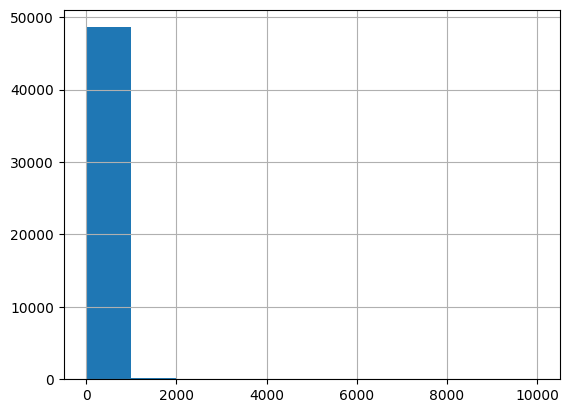

In [10]:
homestay['price'].hist() # most of them are less than 1000
plt.savefig(r'D:\硕士\2023-2024 S2\COMP7103 Data mining\Project\price1.png')

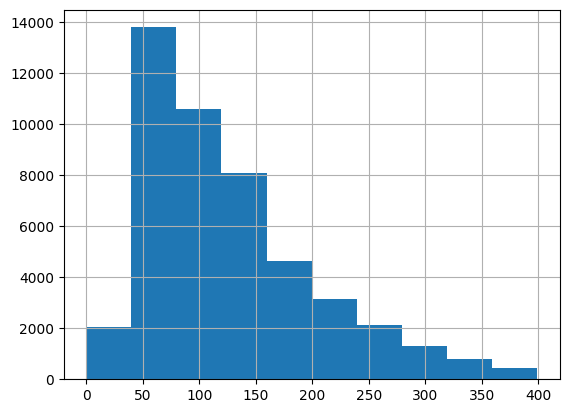

In [11]:
homestay["price"][homestay["price"]<400].hist()
plt.savefig(r'D:\硕士\2023-2024 S2\COMP7103 Data mining\Project\price2.png')

In [12]:
homestay = homestay[homestay["price"]<=400]

In [13]:
homestay["price"].describe()

count    47132.000000
mean       126.405202
std         78.172200
min          0.000000
25%         67.000000
50%        100.000000
75%        165.000000
max        400.000000
Name: price, dtype: float64

In [14]:
homestay['minimum_nights'].describe()

count    47132.000000
mean         6.974391
std         20.343423
min          1.000000
25%          1.000000
50%          2.000000
75%          5.000000
max       1250.000000
Name: minimum_nights, dtype: float64

<AxesSubplot: >

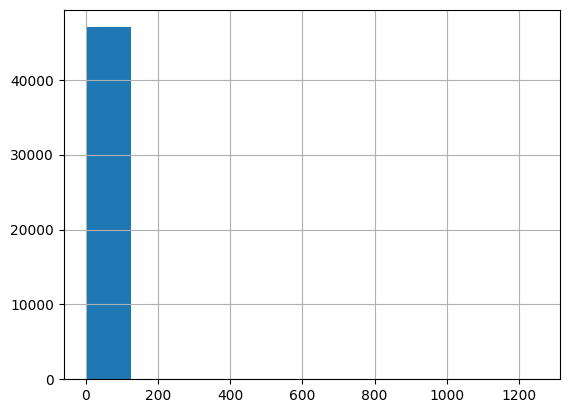

In [15]:
homestay['minimum_nights'].hist()

<AxesSubplot: >

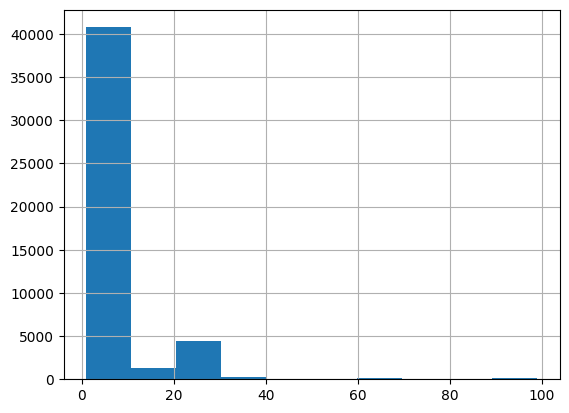

In [16]:
homestay['minimum_nights'][homestay['minimum_nights']<100].hist()

<AxesSubplot: >

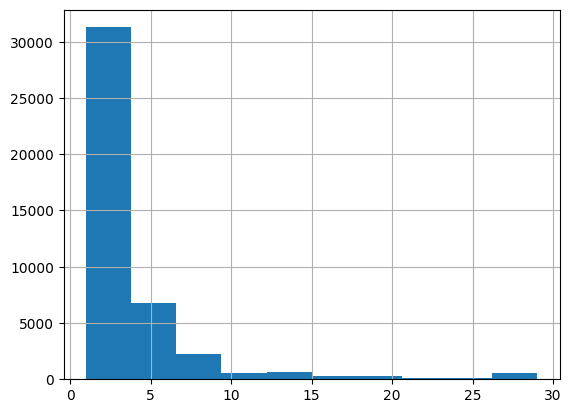

In [17]:
homestay.loc[(homestay.minimum_nights >30),'minimum_nights'] = 30
homestay['minimum_nights'][homestay['minimum_nights']<30].hist() # better distribution

# II. Exploratory analysis

## 1. Categorical Variables Counts

In [18]:
for column in homestay.select_dtypes(include = object):
    print(column,'counts:\n',homestay[column].value_counts(dropna = False))
    print('\n\n')

name counts:
 Hillside Hotel                                        18
Home away from home                                   17
NaN                                                   16
New york Multi-unit building                          14
Brooklyn Apartment                                    12
                                                      ..
Unique 2BR Apartment                                   1
STUNNING ONE BEDROOM IN THE HEART OF NEW YORK CITY     1
One bedroom in Beautiful Astoria with balcony!         1
Elegantly designed 1bd room apt                        1
Trendy duplex in the very heart of Hell's Kitchen      1
Name: name, Length: 46177, dtype: int64



neighbourhood_group counts:
 Manhattan        20366
Brooklyn         19712
Queens            5612
Bronx             1077
Staten Island      365
Name: neighbourhood_group, dtype: int64



neighbourhood counts:
 Williamsburg          3823
Bedford-Stuyvesant    3667
Harlem                2617
Bushwick              245

## 2. Who owns more listings?

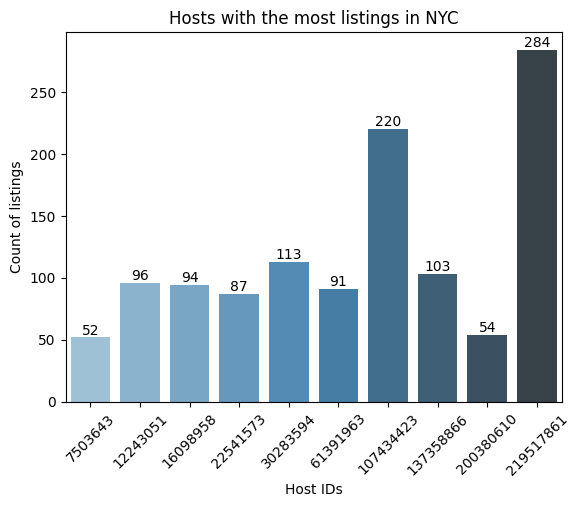

In [19]:
#let's see what hosts (IDs) have the most listings on Airbnb platform and taking advantage of this service
top_host=homestay.host_id.value_counts().head(10)

top_host_df=pd.DataFrame(top_host)
top_host_df.reset_index(inplace=True)
top_host_df.rename(columns={'index':'Host_ID', 'host_id':'Count'}, inplace=True)

viz_1 = sns.barplot(x="Host_ID", y="Count", data=top_host_df, palette='Blues_d')

viz_1.set_title('Hosts with the most listings in NYC')
viz_1.set_ylabel('Count of listings')
viz_1.set_xlabel('Host IDs')
viz_1.set_xticklabels(viz_1.get_xticklabels(), rotation=45)

for p in viz_1.patches:
    viz_1.annotate(format(p.get_height(), '.0f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 5), 
                   textcoords = 'offset points')

plt.show()

## 3. Which borough is more expensive?

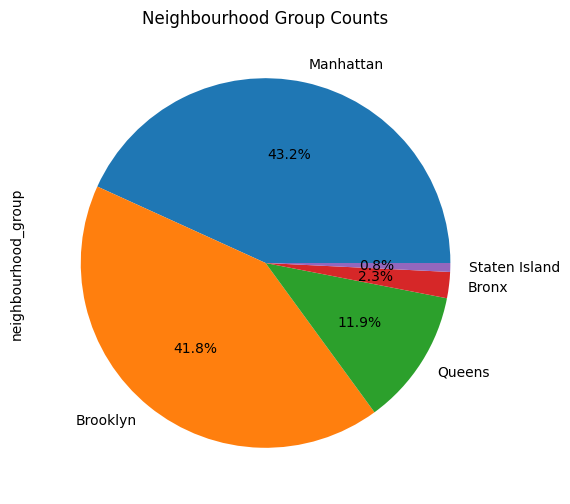

In [20]:
neighbourhood_counts = homestay['neighbourhood_group'].value_counts()

plt.figure(figsize=(8, 6))
neighbourhood_counts.plot(kind='pie', autopct='%1.1f%%')
plt.title("Neighbourhood Group Counts")
plt.show()

In [21]:
#Brooklyn
sub_1 = homestay.loc[homestay['neighbourhood_group'] == 'Brooklyn']
price_sub1 = sub_1[['price']]
#Manhattan
sub_2 = homestay.loc[homestay['neighbourhood_group'] == 'Manhattan']
price_sub2 = sub_2[['price']]
#Queens
sub_3 = homestay.loc[homestay['neighbourhood_group'] == 'Queens']
price_sub3 = sub_3[['price']]
#Staten Island
sub_4 = homestay.loc[homestay['neighbourhood_group'] == 'Staten Island']
price_sub4 = sub_4[['price']]
#Bronx
sub_5 = homestay.loc[homestay['neighbourhood_group'] == 'Bronx']
price_sub5 = sub_5[['price']]

price_list_by_n = [price_sub1, price_sub2, price_sub3, price_sub4, price_sub5]

In [22]:
p_l_b_n_2=[]
nei_list=['Brooklyn', 'Manhattan', 'Queens', 'Staten Island', 'Bronx']
#creating a for loop to get statistics for price ranges and append it to our empty list
for x in price_list_by_n:
    i=x.describe(percentiles=[.25, .50, .75])
    i=i.iloc[3:]
    i.reset_index(inplace=True)
    i.rename(columns={'index':'Stats'}, inplace=True)
    p_l_b_n_2.append(i)

p_l_b_n_2[0].rename(columns={'price':nei_list[0]}, inplace=True)
p_l_b_n_2[1].rename(columns={'price':nei_list[1]}, inplace=True)
p_l_b_n_2[2].rename(columns={'price':nei_list[2]}, inplace=True)
p_l_b_n_2[3].rename(columns={'price':nei_list[3]}, inplace=True)
p_l_b_n_2[4].rename(columns={'price':nei_list[4]}, inplace=True)

stat_df=p_l_b_n_2
stat_df=[df.set_index('Stats') for df in stat_df]
stat_df=stat_df[0].join(stat_df[1:])
stat_df

Brooklyn  Manhattan  Queens  Staten Island  Bronx
Stats                                                   
min         0.0        0.0    10.0           13.0    0.0
25%        60.0       90.0    50.0           50.0   45.0
50%        90.0      140.0    75.0           75.0   65.0
75%       145.0      200.0   110.0          105.0   98.0
max       400.0      400.0   400.0          300.0  399.0

Text(0.5, 1.0, 'Density and distribution of prices for each neighberhood_group')

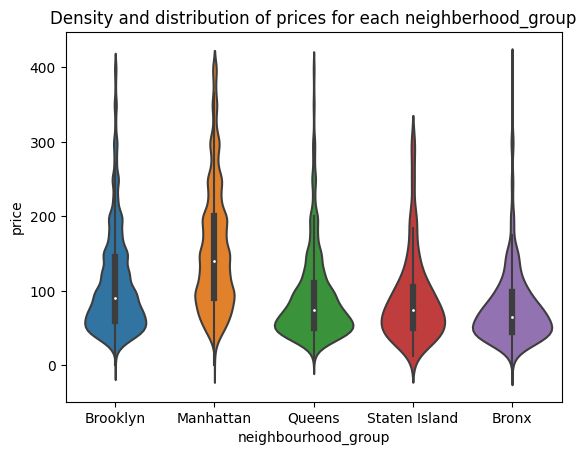

In [23]:
#using violinplot to showcase density and distribtuion of prices 
homestay0 = homestay[homestay.price < 500]
viz_2=sns.violinplot(data=homestay0, x='neighbourhood_group', y='price')
viz_2.set_title('Density and distribution of prices for each neighberhood_group')

In terms of price range, Manhattan stands out as the top contender, boasting the highest prices with an average observation of \\$140 per night. Following closely behind is Brooklyn, with an average price of \\$90 per night. When it comes to Queens and Staten Island, their price distributions appear quite similar, while the Bronx emerges as the most budget-friendly option among them all. 
The variation in prices aligns with our common sense, as Manhattan is renowned for its exorbitant cost of living, while the Bronx is generally considered to have more affordable standards of living.

## 4. Room type and neighbourhoods

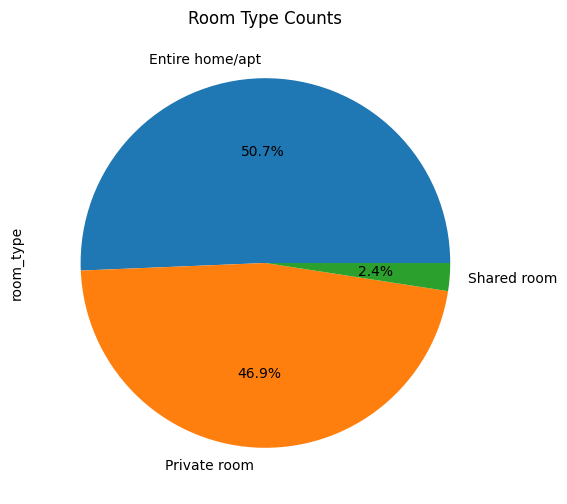

In [24]:
room_type_counts = homestay['room_type'].value_counts()

plt.figure(figsize=(8, 6))
room_type_counts.plot(kind='pie', autopct='%1.1f%%')
plt.title("Room Type Counts")

plt.show()

Text(0.5, 1.0, 'Density and distribution of prices for each neighberhood_group')

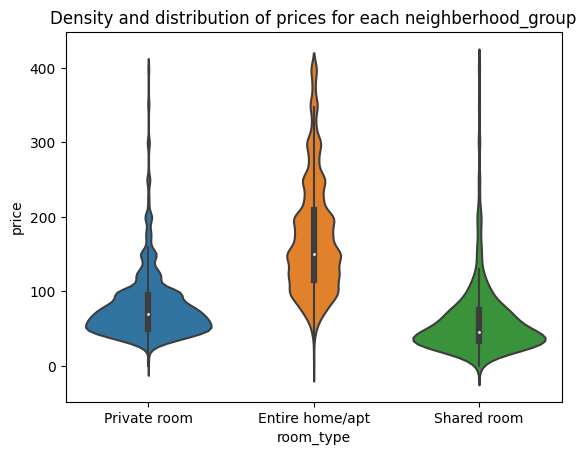

In [25]:
#using violinplot to showcase density and distribtuion of prices 
viz_2=sns.violinplot(data=homestay0, x='room_type', y='price')
viz_2.set_title('Density and distribution of prices for each neighberhood_group')

In [26]:
#as we saw earlier from unique values for neighbourhood there are way too many to concentrate on;
#therefore, let's grab just top 10 neighbourhoods that have the most listings in them
homestay.neighbourhood.value_counts().head(10)

Williamsburg          3823
Bedford-Stuyvesant    3667
Harlem                2617
Bushwick              2454
Upper West Side       1867
Hell's Kitchen        1834
East Village          1774
Upper East Side       1724
Crown Heights         1538
Midtown               1301
Name: neighbourhood, dtype: int64

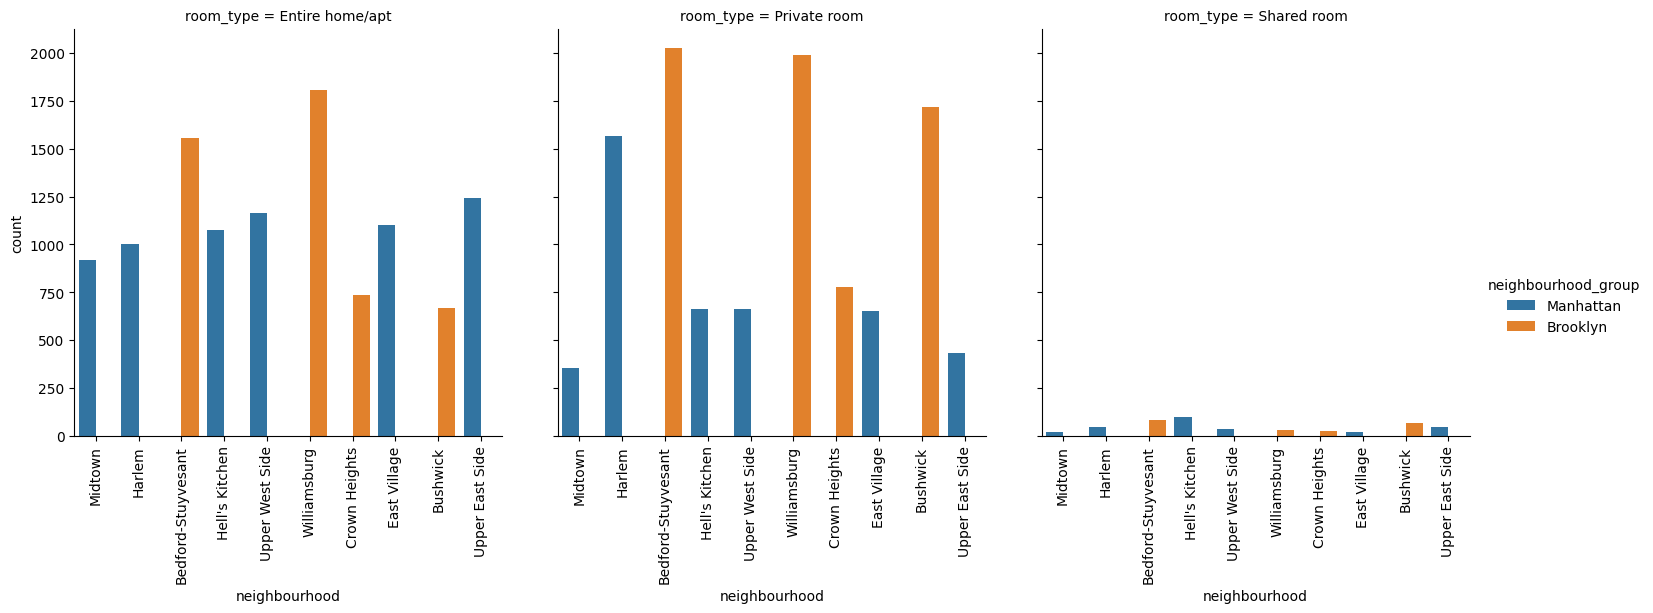

In [27]:
# combine this with boroughs and room type for a rich visualization we can make
sub_7=homestay.loc[homestay['neighbourhood'].isin(['Williamsburg','Bedford-Stuyvesant','Harlem','Bushwick','Upper West Side','Hell\'s Kitchen','East Village','Upper East Side','Crown Heights','Midtown'])]
#using catplot to represent multiple interesting attributes together and a count
viz_3=sns.catplot(x='neighbourhood', hue='neighbourhood_group', col='room_type', data=sub_7, kind='count')
viz_3.set_xticklabels(rotation=90)

3 subplots - divided by room_type

Y and X axes stay exactly the same for each subplot.

'Shared room' type Airbnb listing is barely available among 10 most listing-populated neighborhoods. 

Out of the ten neighborhoods, only two boroughs are featured: Manhattan and Brooklyn. This outcome was somewhat anticipated since Manhattan and Brooklyn are highly attractive travel destinations, resulting in a greater availability of listings in these areas.

Bedford-Stuyvesant and Williamsburg are the most popular for Manhattan borough, and Harlem for Brooklyn.

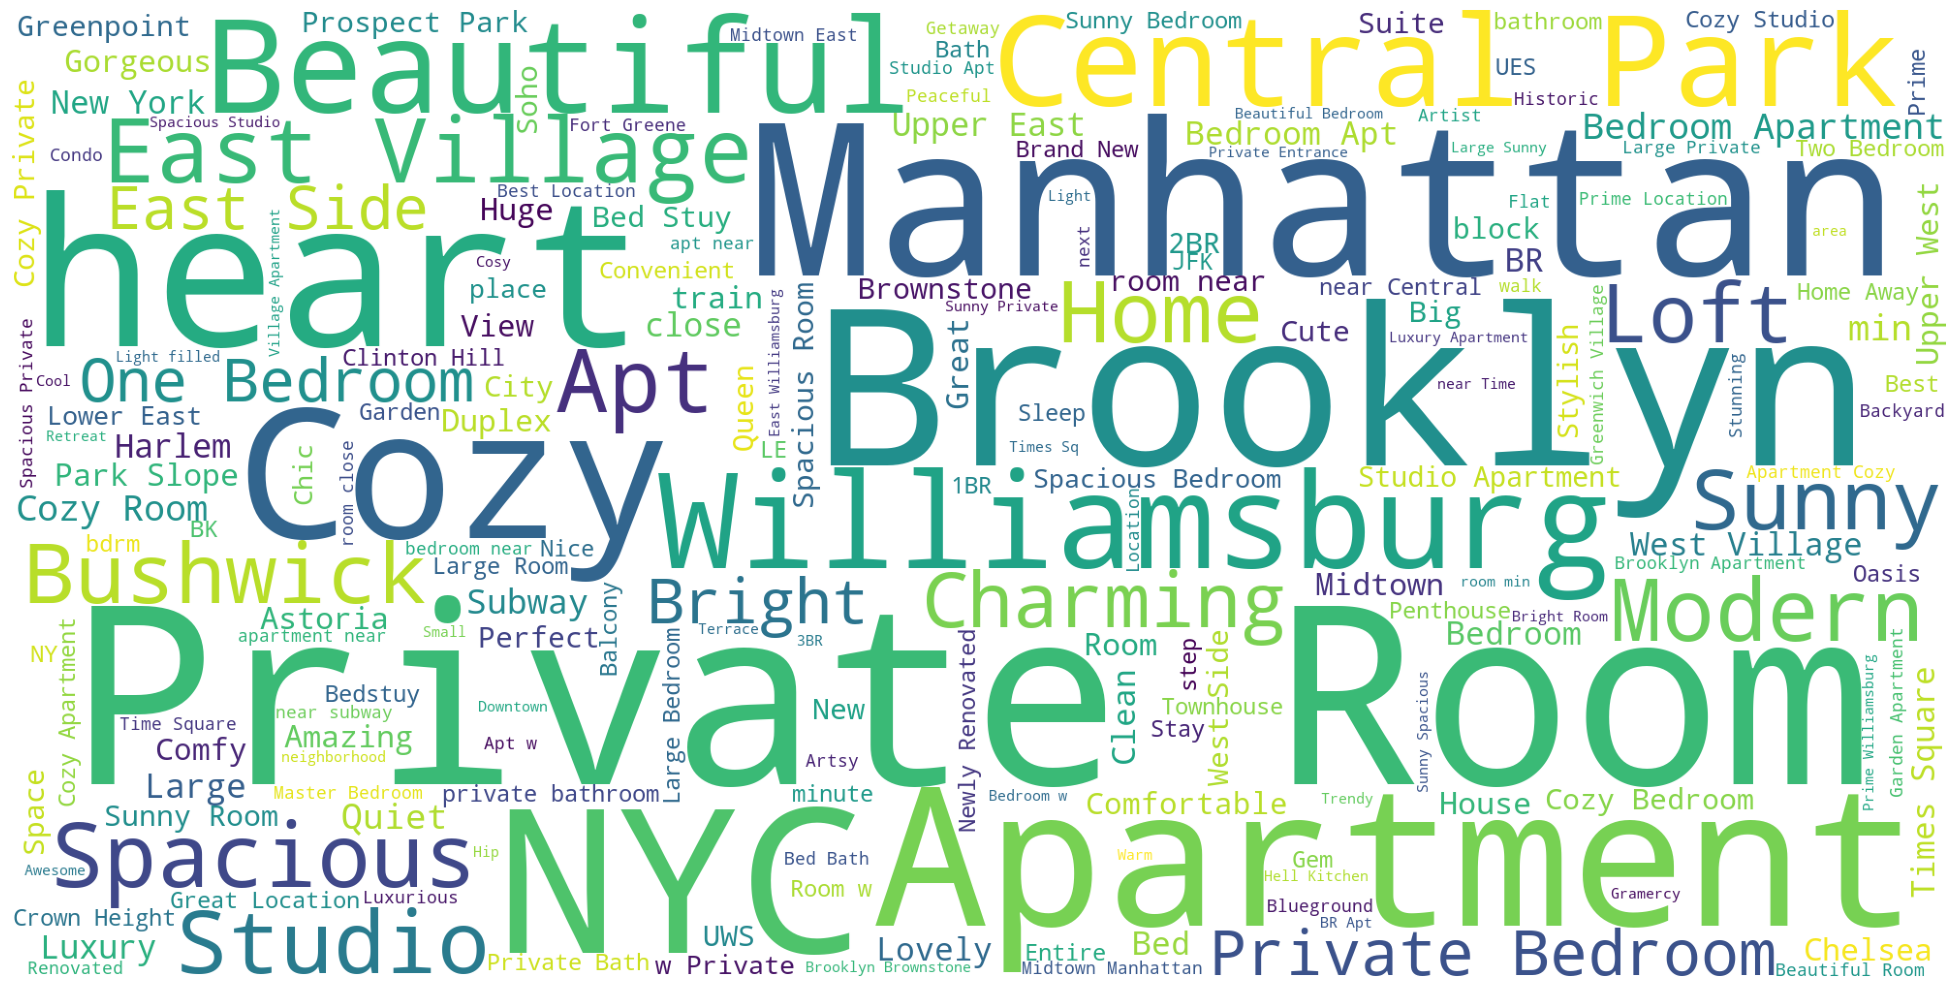

In [28]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud

# 过滤非字符串元素
name_list = [str(name) for name in homestay.name if isinstance(name, str)]

plt.subplots(figsize=(25,15))
wordcloud = WordCloud(
    background_color='white',
    width=2000,
    height=1000
).generate(" ".join(name_list))

plt.imshow(wordcloud)
plt.axis('off')
plt.savefig(r'D:\硕士\2023-2024 S2\COMP7103 Data mining\Project\neighborhood.png')
plt.show()

## 5. Correlations

In [29]:
homestay.drop(['host_id',"latitude",'longitude'], axis=1, inplace=True)
homestay1 = pd.get_dummies(homestay,columns = ['neighbourhood_group','room_type'],drop_first=True)
homestay1.drop(["neighbourhood"], axis=1, inplace=True)

C:\Users\Tommy\AppData\Local\Temp\ipykernel_10520\3333983602.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = homestay1.corr(method = 'kendall')


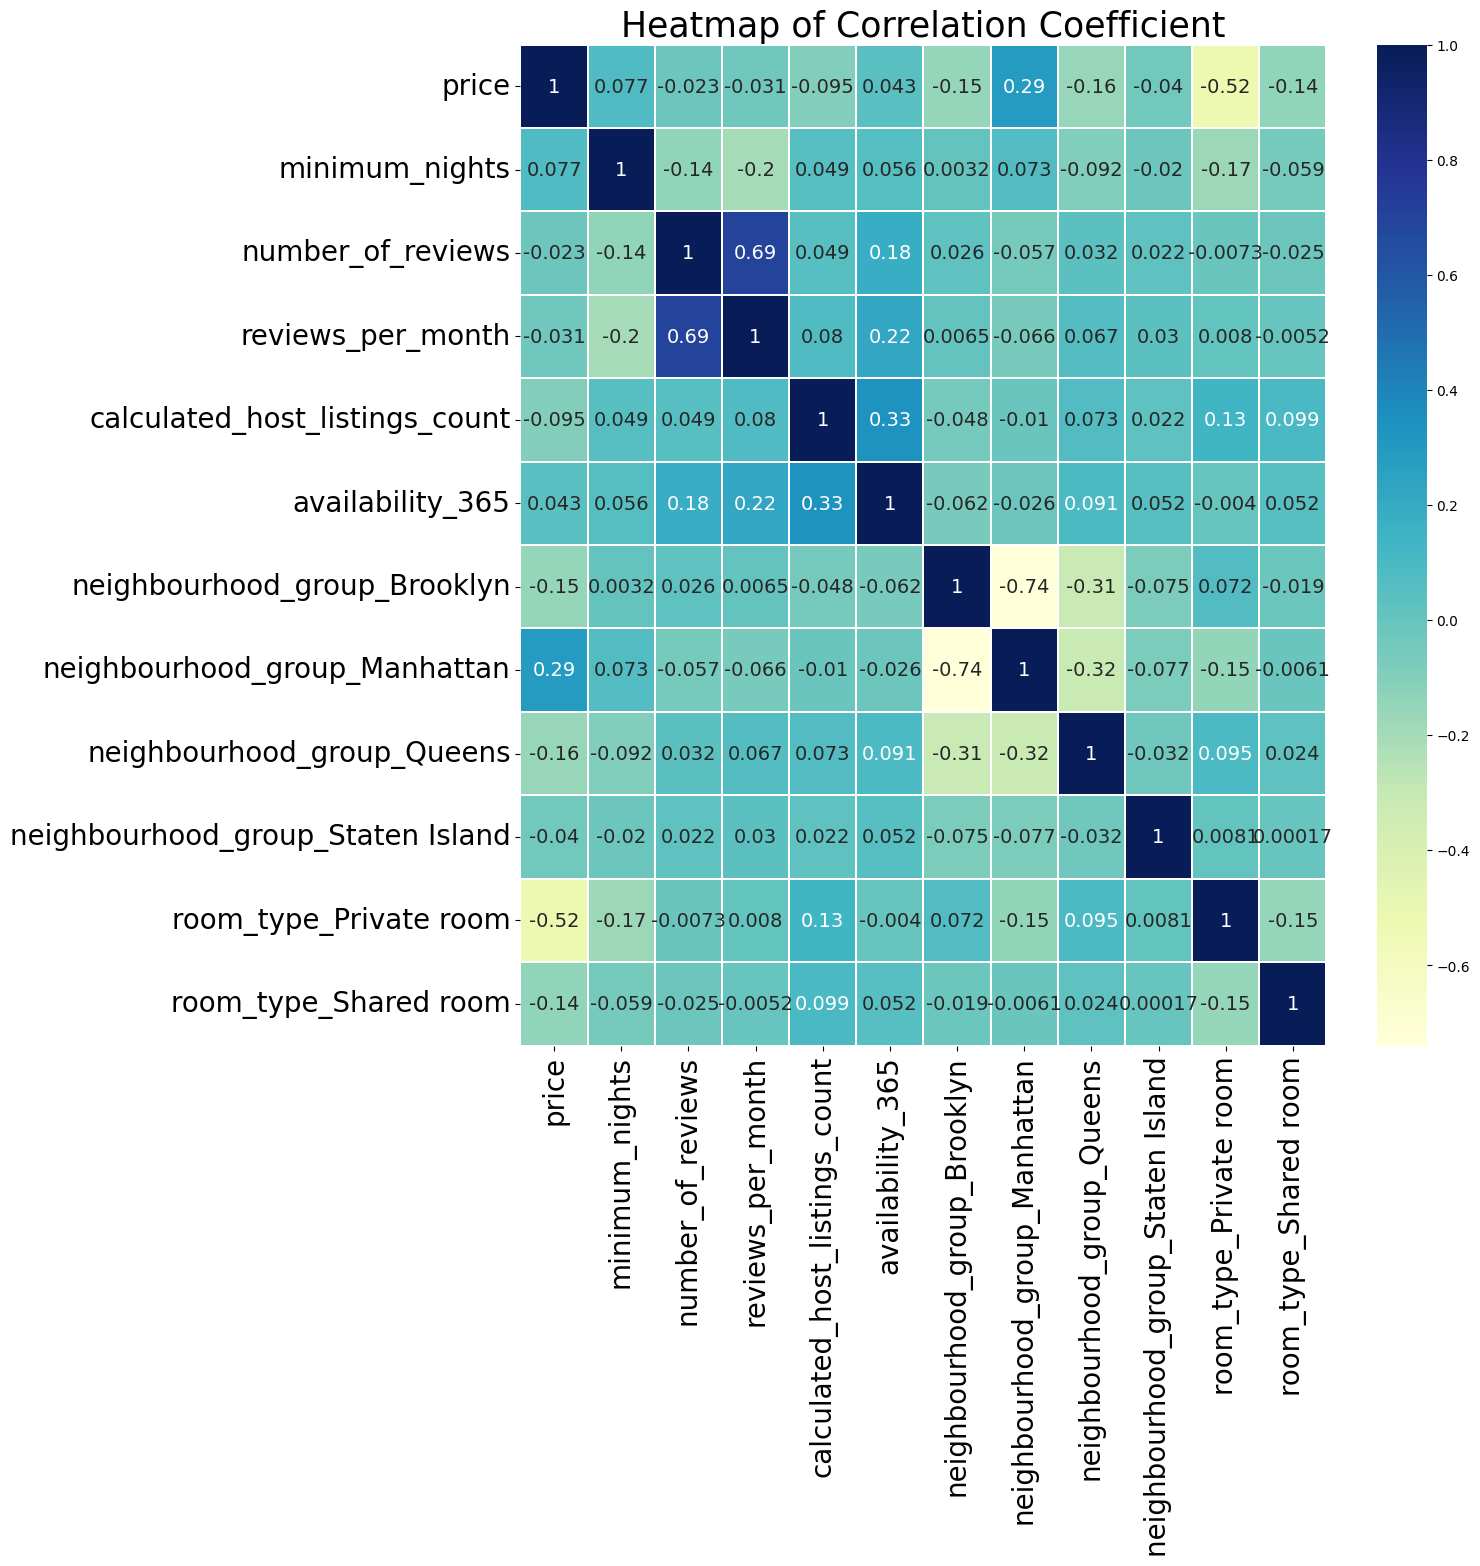

In [30]:
corr = homestay1.corr(method = 'kendall')
plt.figure(figsize = (13, 13))
ax = sns.heatmap(corr, xticklabels = corr.columns, yticklabels = corr.columns, linewidth = 0.2, cmap = 'YlGnBu', annot = True, annot_kws={"fontsize":14}) ## annot:把值打出来，annot_kws: 标注字体大小
ax.set_xticklabels(ax.get_xmajorticklabels(), fontsize = 20) 
ax.set_yticklabels(ax.get_ymajorticklabels(), fontsize = 20) 
plt.title('Heatmap of Correlation Coefficient',fontsize = 25)
plt.show()

# III. Modeling

## 1. Does homestay name imply any price information?

In [31]:
homestay2 = homestay1.copy()
homestay2['name'].fillna('', inplace=True)
homestay2['name'].isnull().sum()

0

In [32]:
import re
def remove_punctuation_digits_specialchar(line):
    return re.sub('[^A-Za-z]+', ' ', line).lower()

homestay2['clean_name'] = homestay2['name'].apply(remove_punctuation_digits_specialchar)
# Compare raw and cleaned texts.
homestay2[['name', 'clean_name']].tail()

name  \
48890    Charming one bedroom - newly renovated rowhouse   
48891      Affordable room in Bushwick/East Williamsburg   
48892            Sunny Studio at Historical Neighborhood   
48893               43rd St. Time Square-cozy single bed   
48894  Trendy duplex in the very heart of Hell's Kitchen   

                                              clean_name  
48890      charming one bedroom newly renovated rowhouse  
48891      affordable room in bushwick east williamsburg  
48892            sunny studio at historical neighborhood  
48893                  rd st time square cozy single bed  
48894  trendy duplex in the very heart of hell s kitchen

In [33]:
import nltk
from nltk.util import ngrams
from nltk.corpus import stopwords

def tokenize_no_stopwords(line):
    tokens = nltk.tokenize.word_tokenize(line)
    tokens_no_stop = [w for w in tokens if w not in stopwords.words('english')]
    return " ".join(tokens_no_stop)
homestay2['final_name'] = homestay2['clean_name'].apply(tokenize_no_stopwords)
homestay2[['name', 'clean_name', 'final_name']].head()

name  \
0                Clean & quiet apt home by the park   
1                             Skylit Midtown Castle   
2               THE VILLAGE OF HARLEM....NEW YORK !   
3                   Cozy Entire Floor of Brownstone   
4  Entire Apt: Spacious Studio/Loft by central park   

                                        clean_name  \
0                 clean quiet apt home by the park   
1                            skylit midtown castle   
2                  the village of harlem new york    
3                  cozy entire floor of brownstone   
4  entire apt spacious studio loft by central park   

                                     final_name  
0                     clean quiet apt home park  
1                         skylit midtown castle  
2                       village harlem new york  
3                  cozy entire floor brownstone  
4  entire apt spacious studio loft central park

In [34]:
from sklearn.feature_extraction.text import TfidfVectorizer
from lightgbm import LGBMRegressor, LGBMClassifier

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, recall_score, f1_score, classification_report, mean_absolute_error, r2_score
from imblearn.over_sampling import SMOTE

def classify_price_category(price):
    if price > 300:
        return 2
    elif price > 100:
        return 1
    else:
        return 0

homestay2['target'] = homestay2['price'].apply(classify_price_category)
homestay2['target'].value_counts()
train, test = train_test_split(homestay2, test_size=0.1, random_state=4, stratify=homestay2['target'])

X_train, y_train = train['final_name'], train['target']
X_test, y_test = test['final_name'], test['target']

vect = TfidfVectorizer()
X_train = vect.fit_transform(X_train)
X_test = vect.transform(X_test)

# over-sampling
smote = SMOTE(random_state=4)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

In [35]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, classification_report


dt = DecisionTreeClassifier(random_state=4)
dt.fit(X_train_resampled, y_train_resampled)
preds = dt.predict(X_test)

# 计算混淆矩阵
cm = confusion_matrix(y_test, preds)

# 定义类别标签映射
label_map = {'0': 'low', '1': 'medium', '2': 'high'}

# 转换混淆矩阵的索引和列名
cm_headers = [f"actual {label_map[str(i)]}" for i in range(cm.shape[0])]
cm_columns = [f"predicted {label_map[str(i)]}" for i in range(cm.shape[1])]
cm = pd.DataFrame(cm, columns=cm_columns, index=cm_headers)

# 打印混淆矩阵
print("混淆矩阵:")
print(cm.astype(int))

# 生成分类报告,调整类别标签
cr = classification_report(y_test, preds, target_names=label_map.values(), digits=3)

# 打印分类报告
print("\n分类报告:")
print(cr)

混淆矩阵:
               predicted low  predicted medium  predicted high
actual low              1655               700              38
actual medium            651              1365             145
actual high               31                94              35

分类报告:
              precision    recall  f1-score   support

         low      0.708     0.692     0.700      2393
      medium      0.632     0.632     0.632      2161
        high      0.161     0.219     0.185       160

    accuracy                          0.648      4714
   macro avg      0.500     0.514     0.506      4714
weighted avg      0.655     0.648     0.651      4714



In [36]:
lr = LGBMClassifier(random_state=4)
lr.fit(X_train_resampled, y_train_resampled)
preds = lr.predict(X_test)

# 计算混淆矩阵
cm = confusion_matrix(y_test, preds)

# 定义类别标签映射
label_map = {'0': 'low', '1': 'medium', '2': 'high'}

# 转换混淆矩阵的索引和列名
cm_headers = [f"actual {label_map[str(i)]}" for i in range(cm.shape[0])]
cm_columns = [f"predicted {label_map[str(i)]}" for i in range(cm.shape[1])]
cm = pd.DataFrame(cm, columns=cm_columns, index=cm_headers)

# 打印混淆矩阵
print("混淆矩阵:")
print(cm.astype(int))

# 生成分类报告,调整类别标签
cr = classification_report(y_test, preds, target_names=label_map.values(), digits=3)

# 打印分类报告
print("\n分类报告:")
print(cr)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.160110 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 59554
[LightGBM] [Info] Number of data points in the train set: 64605, number of used features: 960
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
混淆矩阵:
               predicted low  predicted medium  predicted high
actual low              1754               607              32
actual medium            551              1491             119
actual high               26                94              40

分类报告:
              precision    recall  f1-score   support

         low      0.752     0.733     0.743      2393
      medium      0.680     0.690     0.685      2161
        high      0.209     0.250     0.228       160

    accuracy                          0.697      4714
   macro a

## 2. How to price?

###  (1) Linear Regression

In [37]:
homestay1.drop(['name'], axis=1, inplace=True)

In [52]:
X = homestay1.loc[:,homestay1.columns != 'price']
y = homestay1['price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=4)

In [53]:
linreg = LinearRegression().fit(X_train, y_train)
y_pred = linreg.predict(X_test)
print('R² = ',linreg.score(X_train, y_train).round(3))
print ('RMSE = %.3f'%np.sqrt(metrics.mean_squared_error(y_test, y_pred))) 

R² =  0.438
RMSE = 60.241


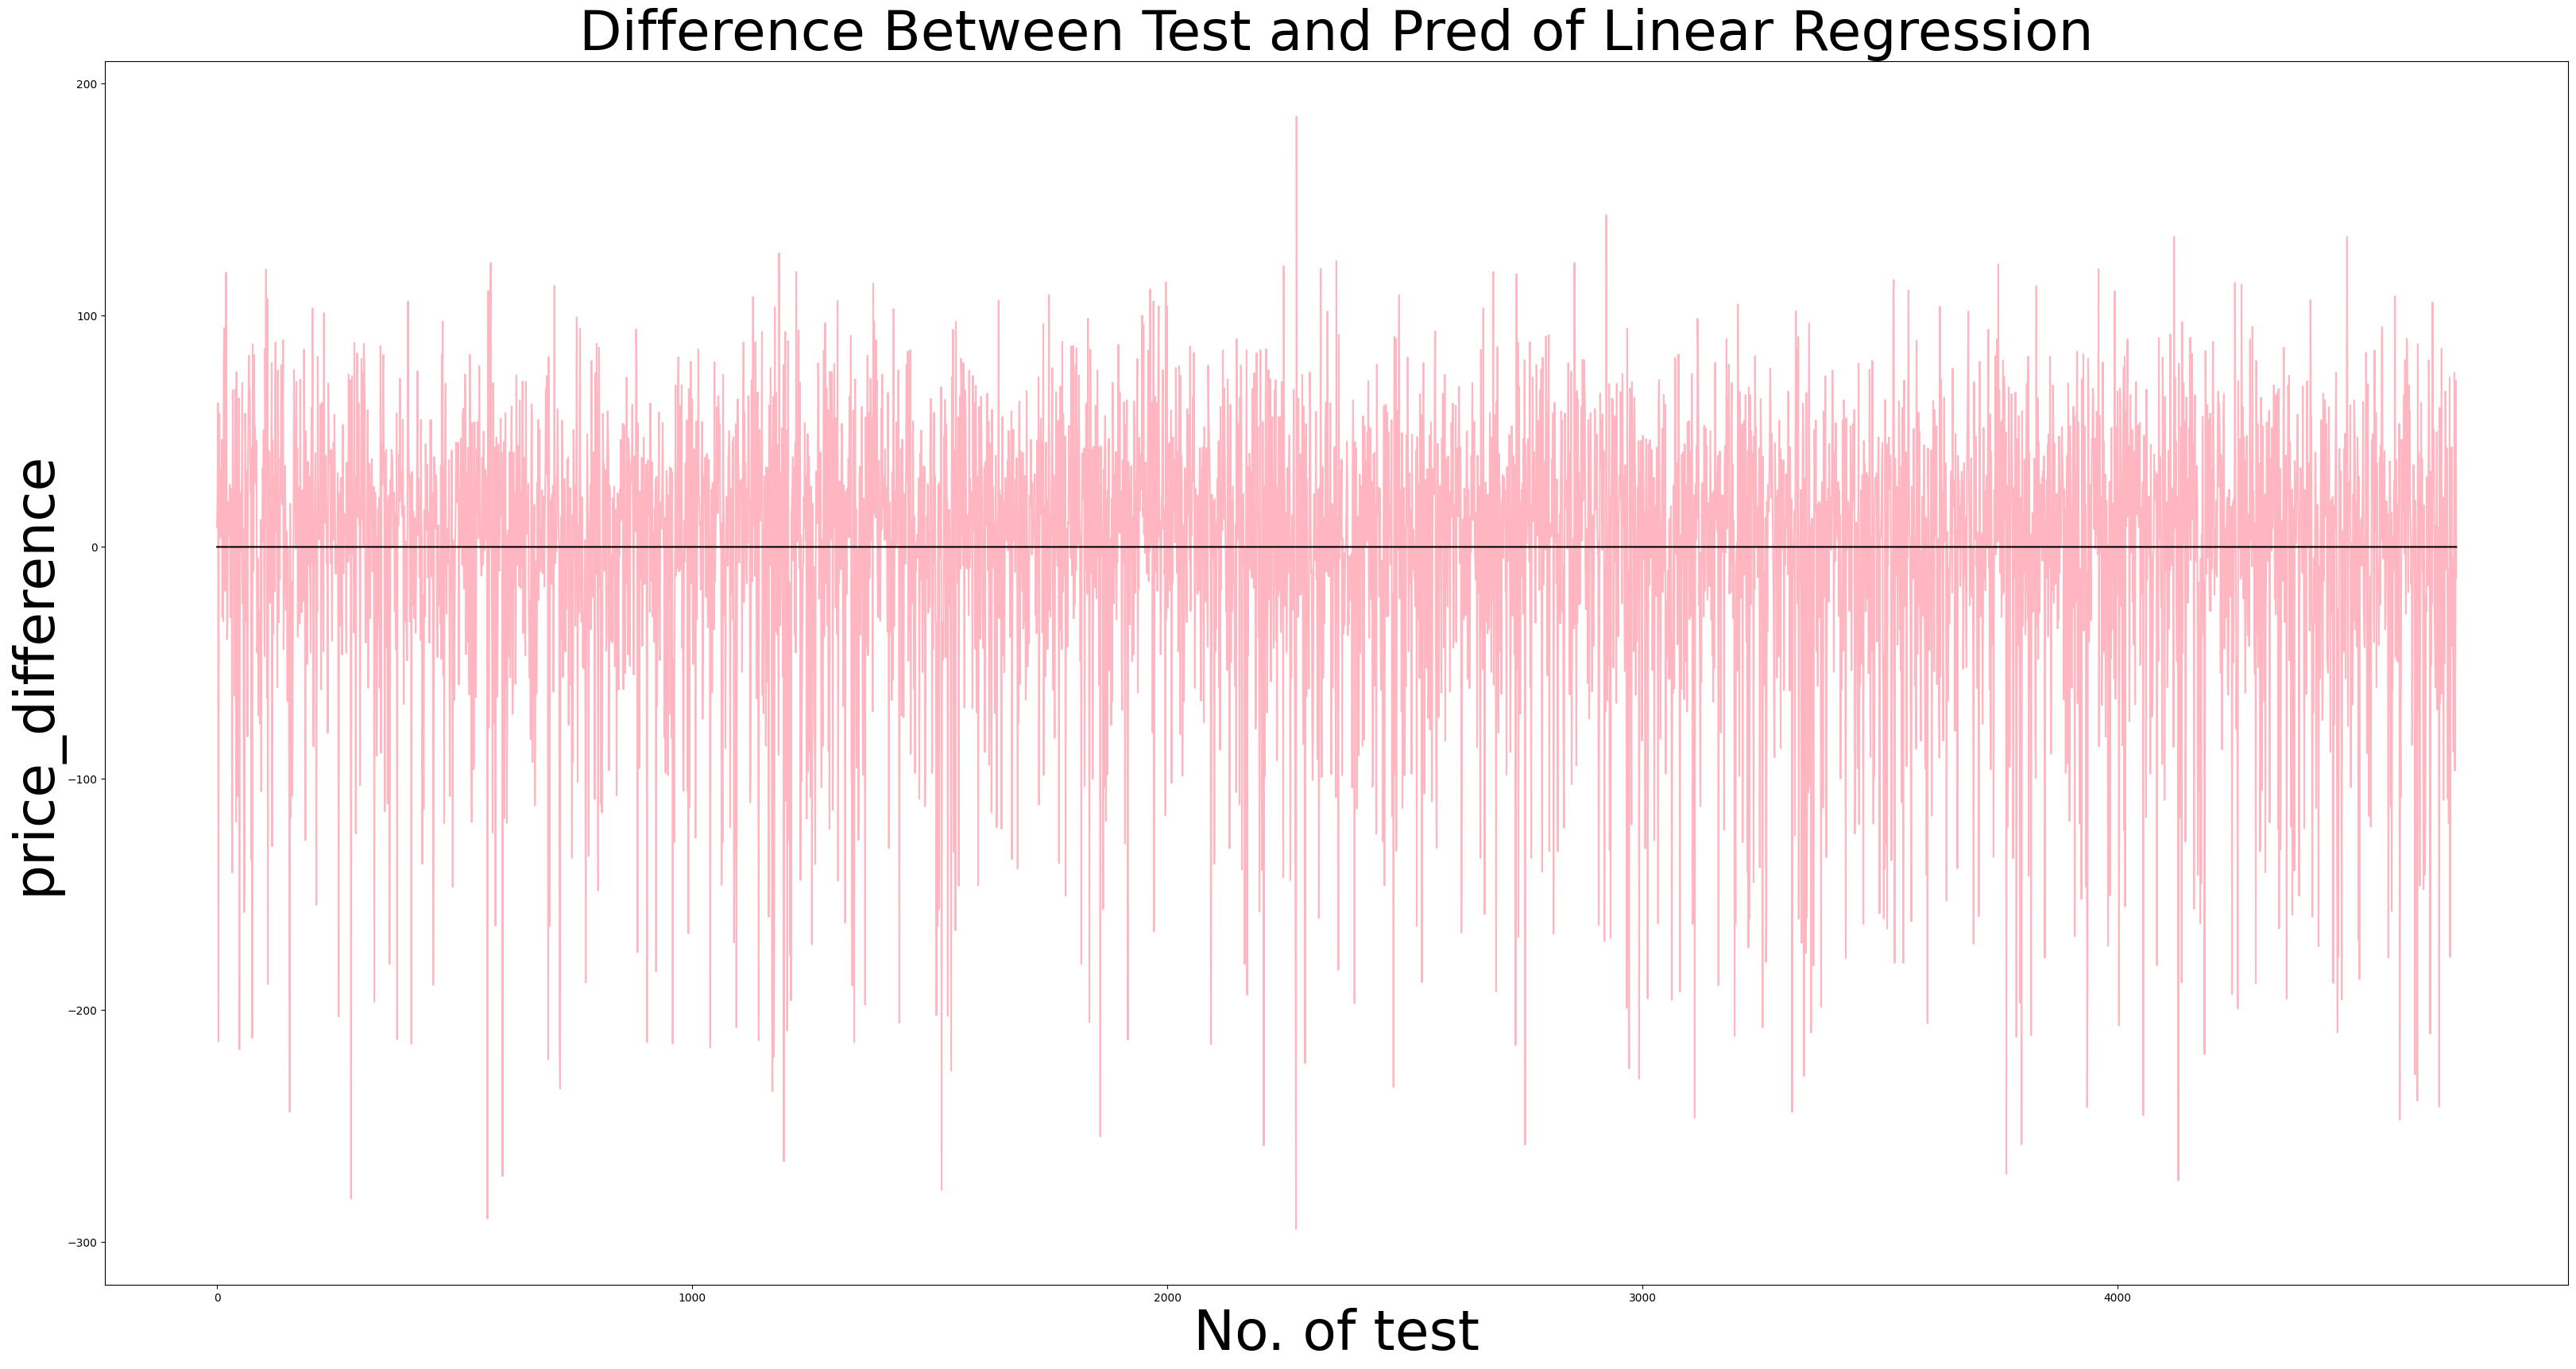

In [54]:
# Difference between test and pred
plt.figure(figsize = (40,20))
plt.plot(range(len(y_pred)),y_pred-y_test,'lightpink')
plt.plot(range(len(y_pred)),np.zeros(4714),'black')
plt.ylim = (-300,200)
plt.title('Difference Between Test and Pred of Linear Regression',fontsize = 50)
plt.xlabel('No. of test',fontsize = 50)
plt.ylabel('price_difference',fontsize = 50)
plt.savefig(r'D:\硕士\2023-2024 S2\COMP7103 Data mining\Project\result figure\difference_LR')

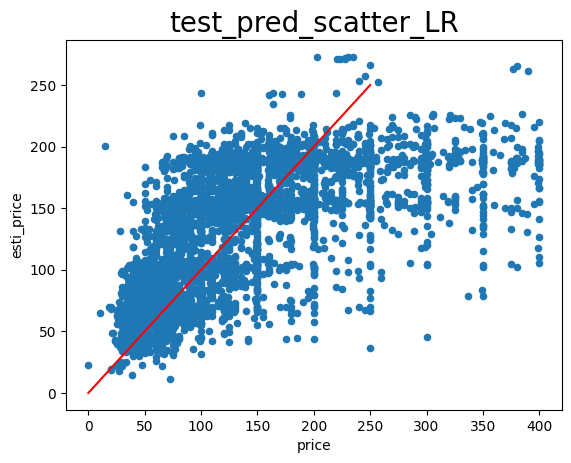

In [55]:
# estimated - actual price plot
test_pred = pd.DataFrame(y_test)
test_pred['esti_price'] = y_pred

test_pred.plot(x='price',y='esti_price',kind='scatter',fontsize = 10)
plt.title('test_pred_scatter_LR',fontsize = 20)
x = np.linspace(0,250)
y=x
plt.plot(x,y,'r')
plt.xlim = ([0,400])
plt.ylim = ([0,500])
plt.savefig(r'D:\硕士\2023-2024 S2\COMP7103 Data mining\Project\result figure\difference_scatter_LR')

### (2) Lasso Regression

In [56]:
homestay3 = homestay.copy()
homestay3.drop(['name'], axis=1, inplace=True)
homestay3 = pd.get_dummies(homestay3, columns=['neighbourhood_group', 'neighbourhood', 'room_type'], drop_first=True)

X1 = homestay3.loc[:, homestay3.columns != 'price']
y1 = homestay3['price']

X_train1, X_test1, y_train1, y_test1 = train_test_split(X1, y1, test_size=0.1, random_state=4)

Lassoreg = Lasso(alpha=0.01)
Lassoreg.fit(X_train1, y_train1)

Lasso(alpha=0.01)

In [57]:
coef_dict = dict(zip(X_train1.columns, Lassoreg.coef_.round(3)))
sorted(coef_dict.items(),key = lambda x:x[1],reverse = True)

[('neighbourhood_DUMBO', 75.086),
 ('neighbourhood_group_Manhattan', 64.846),
 ('neighbourhood_Tribeca', 56.408),
 ('neighbourhood_Vinegar Hill', 52.385),
 ('neighbourhood_NoHo', 37.058),
 ('neighbourhood_Boerum Hill', 36.569),
 ('neighbourhood_Downtown Brooklyn', 35.689),
 ('neighbourhood_Park Slope', 34.326),
 ('neighbourhood_Williamsburg', 33.877),
 ('neighbourhood_Cobble Hill', 33.682),
 ('neighbourhood_Midtown', 32.98),
 ('neighbourhood_Gowanus', 32.047),
 ('neighbourhood_Carroll Gardens', 29.884),
 ('neighbourhood_Brooklyn Heights', 29.879),
 ('neighbourhood_South Slope', 29.444),
 ('neighbourhood_Fort Greene', 28.481),
 ('neighbourhood_Flatiron District', 27.209),
 ('neighbourhood_Greenpoint', 25.317),
 ('neighbourhood_Prospect Heights', 24.843),
 ('neighbourhood_Theater District', 24.548),
 ('neighbourhood_West Village', 24.164),
 ('neighbourhood_Long Island City', 23.895),
 ('neighbourhood_Clinton Hill', 22.603),
 ('neighbourhood_Arverne', 21.059),
 ('neighbourhood_Greenwich V

In [58]:
print('R² = ',Lassoreg.score(X_train1, y_train1).round(3))
y_pred1= Lassoreg.predict(X_test1)
print ('RMSE1 =%.3f'%np.sqrt(metrics.mean_squared_error(y_test1, y_pred1))) # 均方根误差

R² =  0.501
RMSE1 =56.840


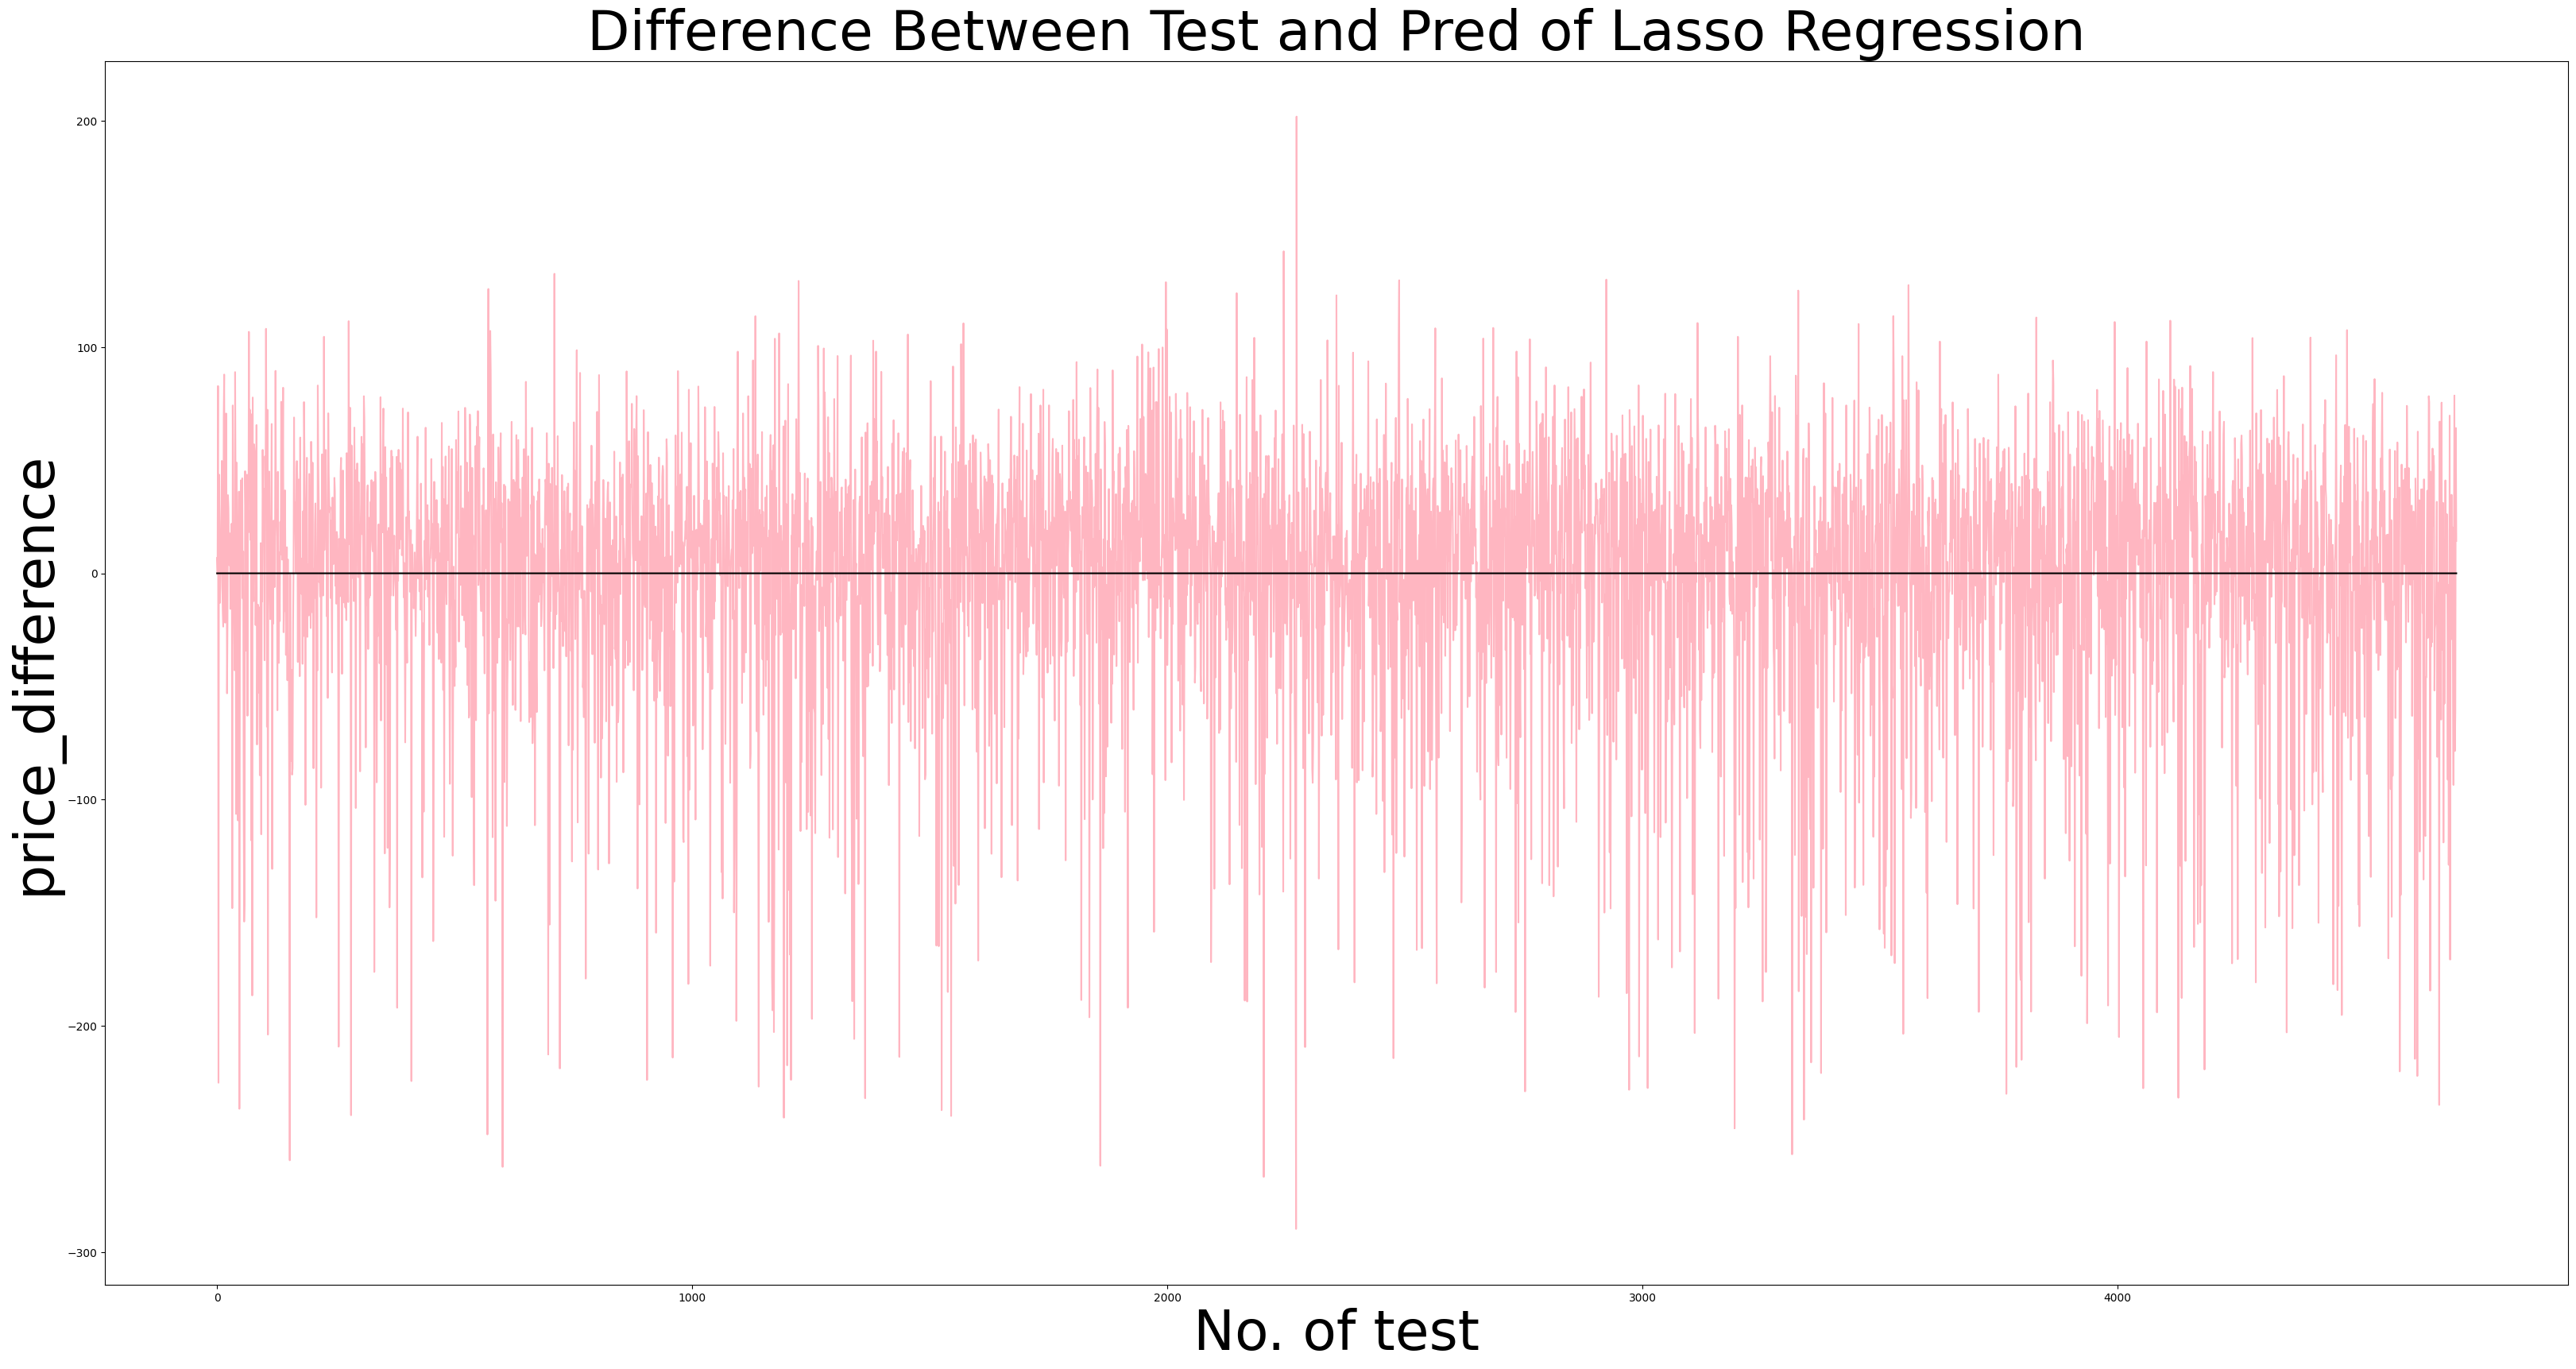

In [59]:
# Difference between test and pred
plt.figure(figsize = (40,20))
plt.plot(range(len(y_pred1)),y_pred1-y_test1,'lightpink')
plt.plot(range(len(y_pred1)),np.zeros(4714),'black')
plt.ylim = (-300,200)
plt.title('Difference Between Test and Pred of Lasso Regression',fontsize = 50)
plt.xlabel('No. of test',fontsize = 50)
plt.ylabel('price_difference',fontsize = 50)
plt.savefig(r'D:\硕士\2023-2024 S2\COMP7103 Data mining\Project\result figure\difference_Lasso')

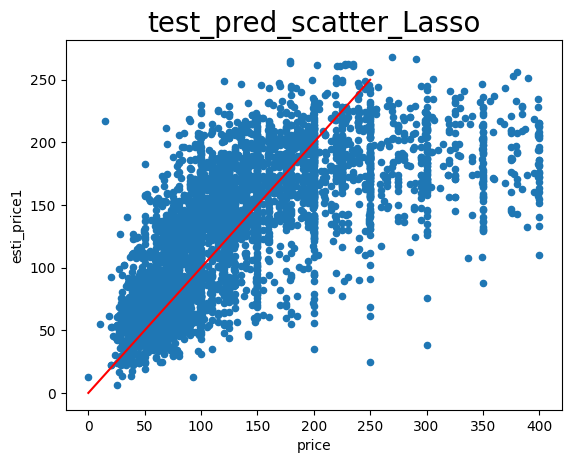

In [60]:
# estimated - actual price scatter plot
y_pred1 = Lassoreg.predict(X_test1)
test_pred1 = pd.DataFrame(y_test1)
test_pred1['esti_price1'] = y_pred1

test_pred1.plot(x='price',y='esti_price1',kind='scatter',fontsize = 10)
plt.title('test_pred_scatter_Lasso',fontsize = 20)
x = np.linspace(0,250)
y=x
plt.plot(x,y,'r')
plt.savefig(r'D:\硕士\2023-2024 S2\COMP7103 Data mining\Project\result figure\difference_scatter_Lasso')
# distributed closer to 45° line

### (3) Decision Tree

In [61]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
import random

# Set random seed
random.seed(4)
np.random.seed(4)

param_grid = {"ccp_alpha": np.linspace(0, 1, 11)}
reg_tree = DecisionTreeRegressor()

# Pruning
grid_search = GridSearchCV(reg_tree, param_grid, scoring='neg_mean_squared_error', cv=10, n_jobs=-1)
grid_search.fit(X_train1, y_train1)

# Print scores for each parameter combination
print("Scores for each parameter combination:")
means = -grid_search.cv_results_['mean_test_score']
stds = grid_search.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, grid_search.cv_results_['params']):
    print("CCP Alpha: %0.3f, RMSE: %0.3f (+/- %0.3f)" % (params['ccp_alpha'], np.sqrt(mean), std))

best_alpha = grid_search.best_params_['ccp_alpha']
print("最优alpha: ", best_alpha)

Scores for each parameter combination:
CCP Alpha: 0.000, RMSE: 71.617 (+/- 154.575)
CCP Alpha: 0.100, RMSE: 68.532 (+/- 145.786)
CCP Alpha: 0.200, RMSE: 66.136 (+/- 176.150)
CCP Alpha: 0.300, RMSE: 63.739 (+/- 173.981)
CCP Alpha: 0.400, RMSE: 61.444 (+/- 151.295)
CCP Alpha: 0.500, RMSE: 59.864 (+/- 136.280)
CCP Alpha: 0.600, RMSE: 58.598 (+/- 168.957)
CCP Alpha: 0.700, RMSE: 57.401 (+/- 125.402)
CCP Alpha: 0.800, RMSE: 56.366 (+/- 125.908)
CCP Alpha: 0.900, RMSE: 55.992 (+/- 108.717)
CCP Alpha: 1.000, RMSE: 55.666 (+/- 108.540)
最优alpha:  1.0


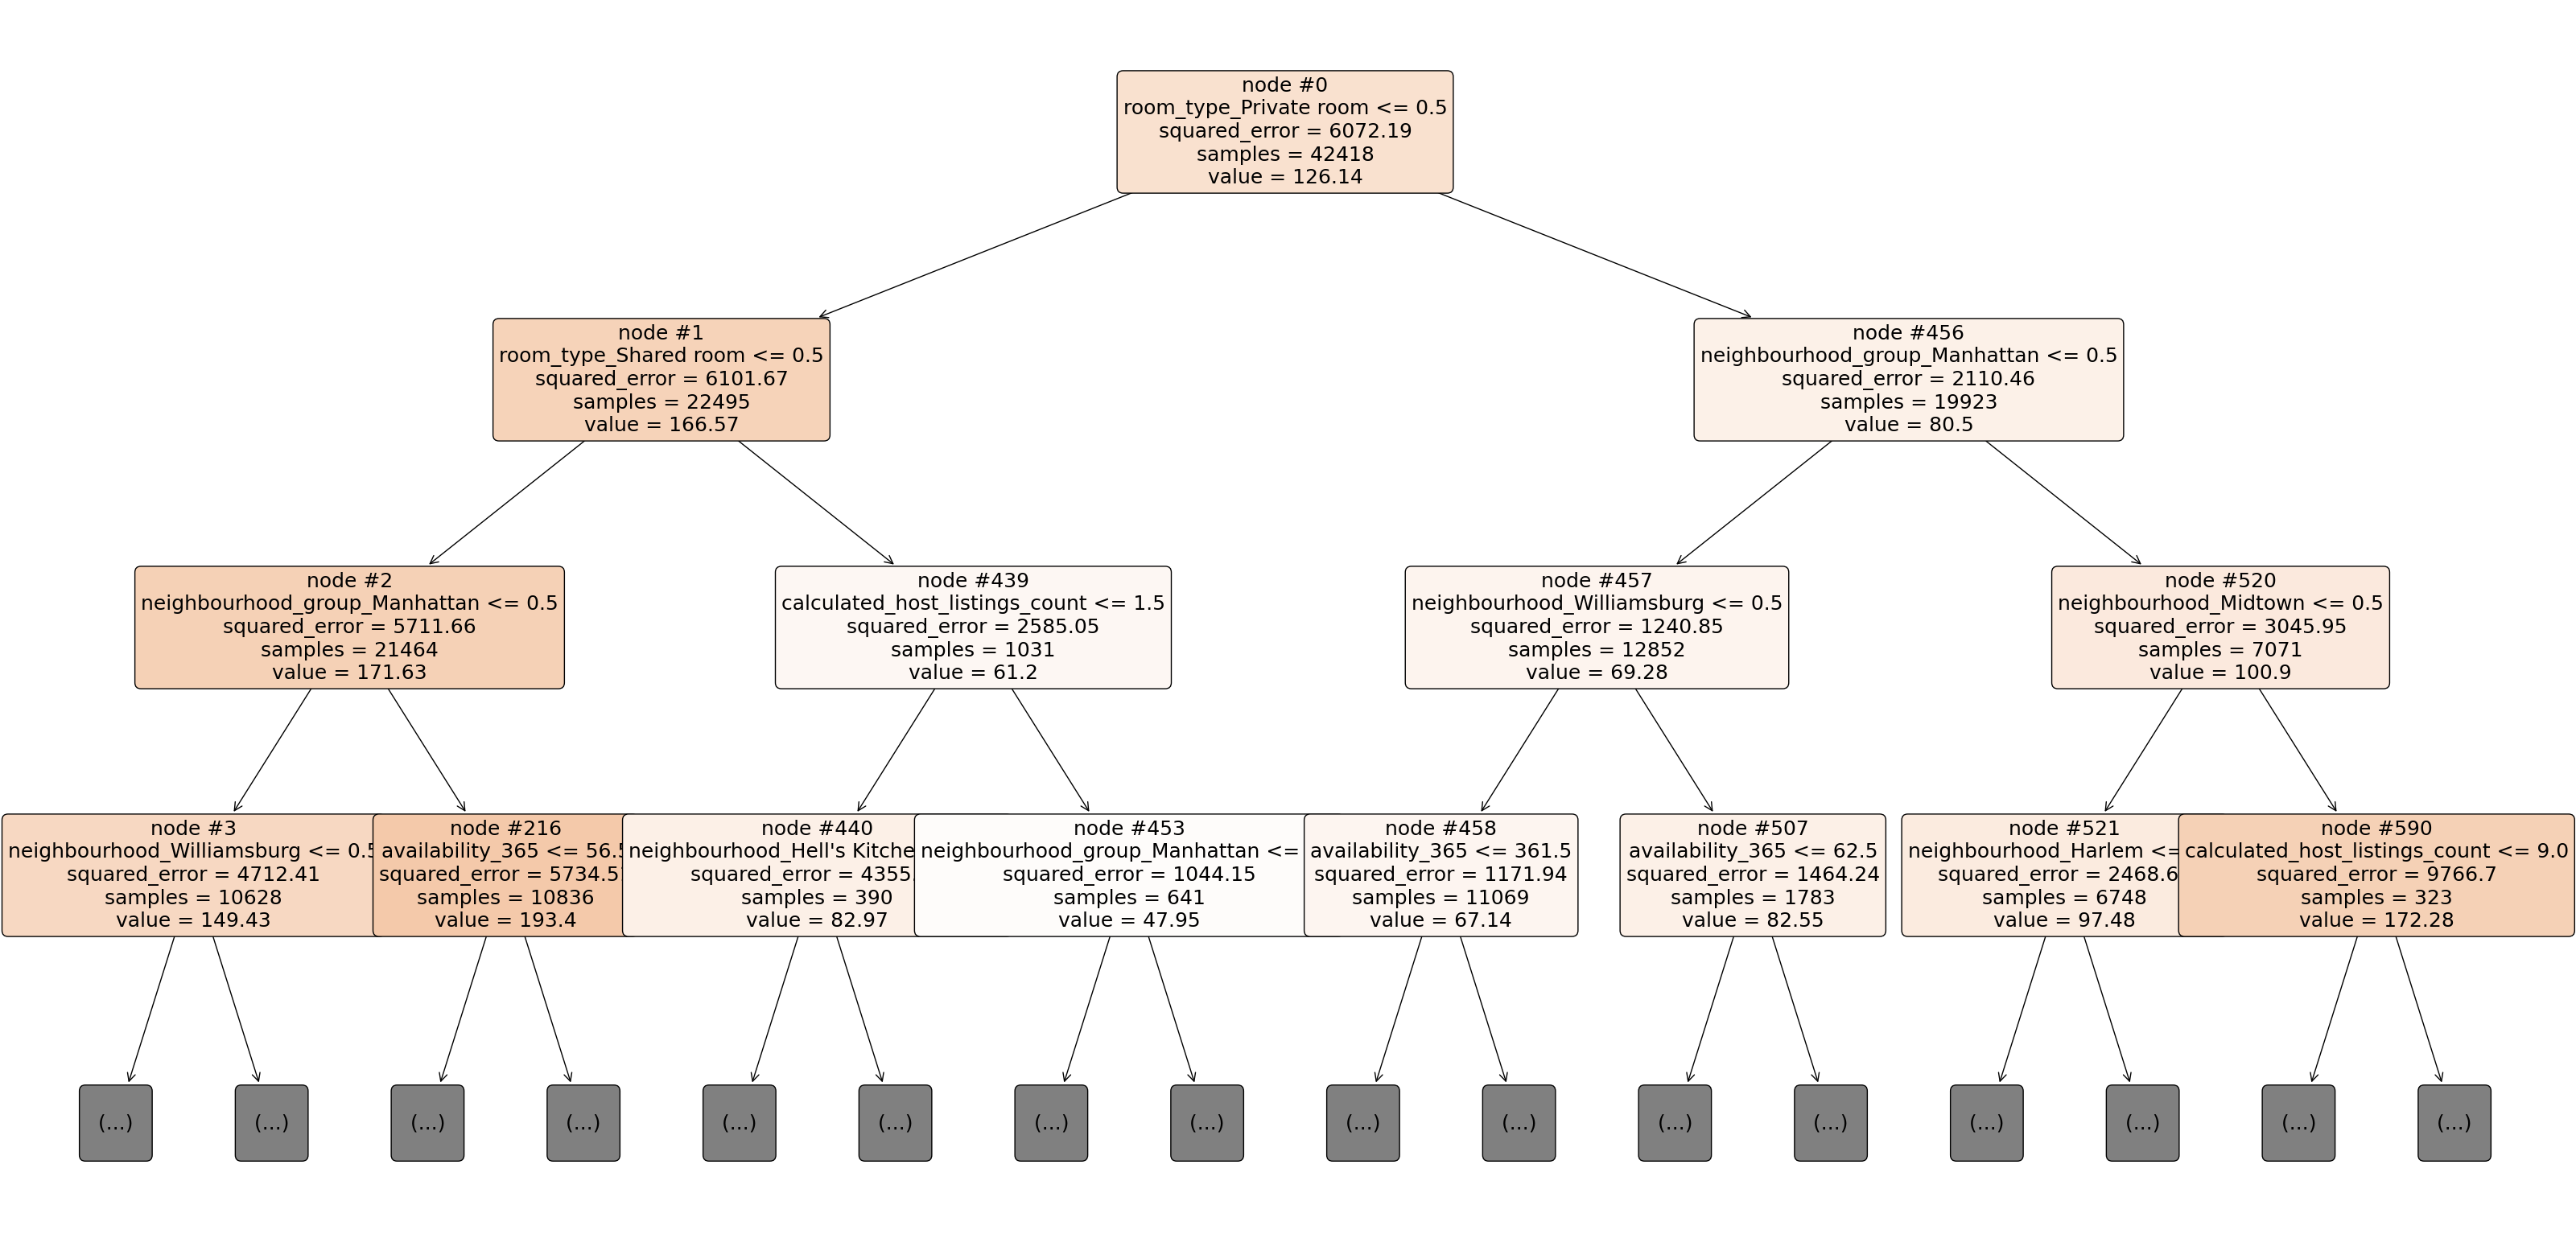

In [62]:
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree

# Fit using the best alpha
feature_names = list(X_train1.columns)
best_reg_tree = DecisionTreeRegressor(ccp_alpha=best_alpha, random_state=4)
best_reg_tree.fit(X_train1, y_train1)

plt.figure(figsize=(40, 20))

# 使用 max_depth 参数限制树的深度
plot_tree(best_reg_tree, filled=True, feature_names=feature_names, class_names=['price'],
           rounded=True, precision=2, impurity=True, node_ids=True, proportion=False,
           fontsize=18, label='all', max_depth=3)  # 设置 max_depth 为 3
plt.savefig(r'D:\硕士\2023-2024 S2\COMP7103 Data mining\Project\result figure\decision_tree')

In [64]:
y_pred1 = best_reg_tree.predict(X_test1)

mse = mean_squared_error(y_test1, y_pred1)
rmse = np.sqrt(mse)
print("测试集上的均方根误差: ", round(rmse, 3))
print('R² = ', best_reg_tree.score(X_train1, y_train1).round(3))

测试集上的均方根误差:  56.828
R² =  0.568


### (3) Random Forest

In [65]:
regrf = RandomForestRegressor(n_estimators=300) 
regrf.fit(X_train1, y_train1)

RandomForestRegressor(n_estimators=300)

room_type_Private room        0.316
availability_365              0.111
reviews_per_month             0.105
number_of_reviews             0.081
minimum_nights                0.070
                              ...  
neighbourhood_Richmondtown    0.000
neighbourhood_Westerleigh     0.000
neighbourhood_Rossville       0.000
neighbourhood_Co-op City      0.000
neighbourhood_Silver Lake     0.000
Length: 229, dtype: float64


Text(0.5, 0, 'Relative Importance')

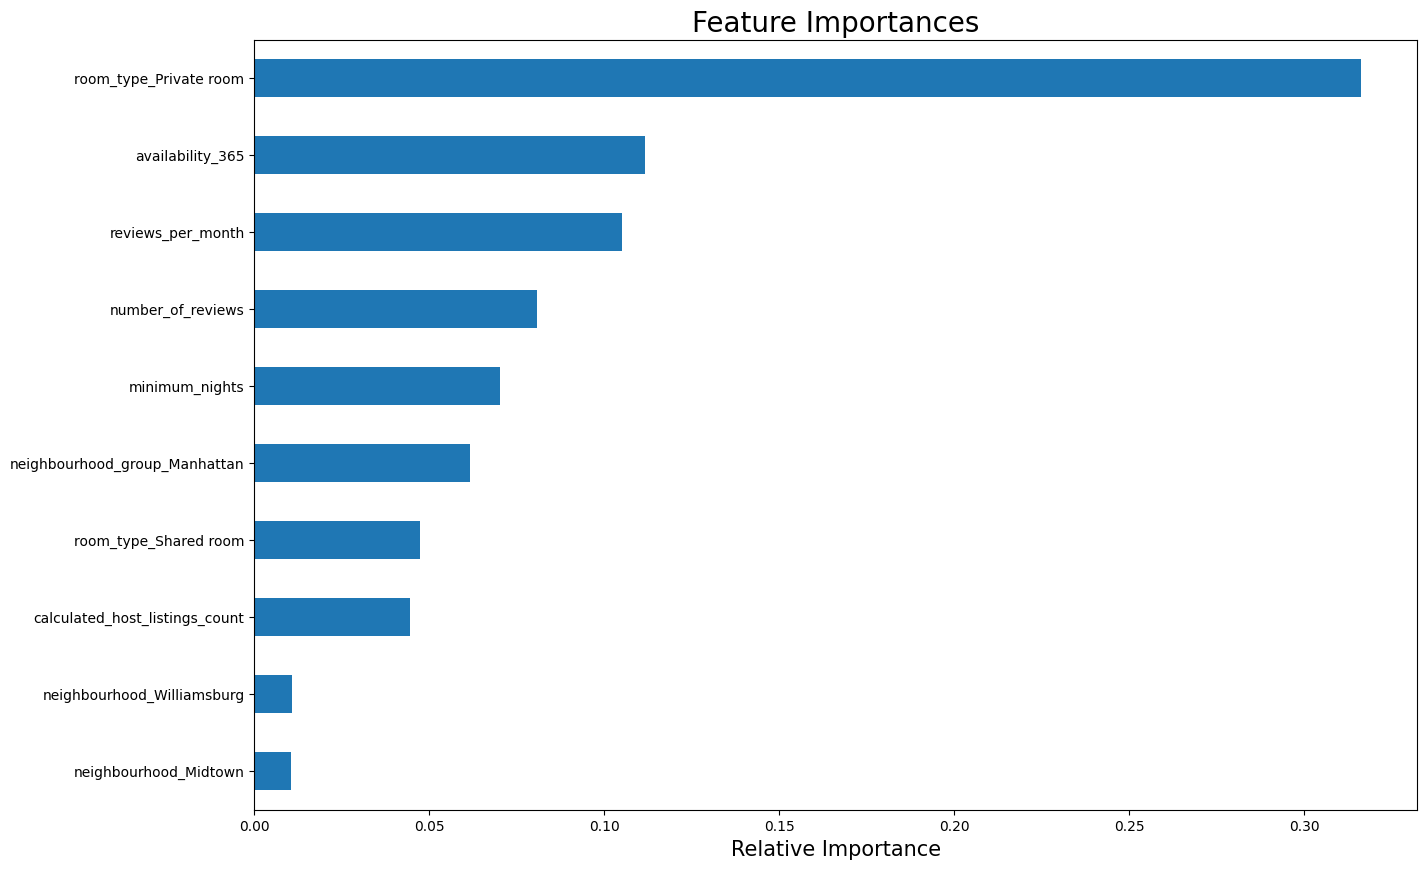

In [66]:
# Feature importance
importances = regrf.feature_importances_
weights = pd.Series(importances,
                 index=X_train1.columns.values)
print(weights.sort_values(ascending = False).round(3))

plt.figure(figsize=(15,10))
plt.title('Feature Importances',fontsize = 20)
weights.sort_values()[-10:].plot(kind = 'barh')
plt.xlabel('Relative Importance',fontsize = 15)

In [67]:
print('R² = ',regrf.score(X_train1, y_train1).round(3))
y_predrf= regrf.predict(X_test1)
print('RMSE = ',np.sqrt(metrics.mean_squared_error(y_test1,y_predrf)).round(3))
# Coefficient of determinationR² is up to 89.6%，too high to overfitting

R² =  0.896
RMSE =  55.668


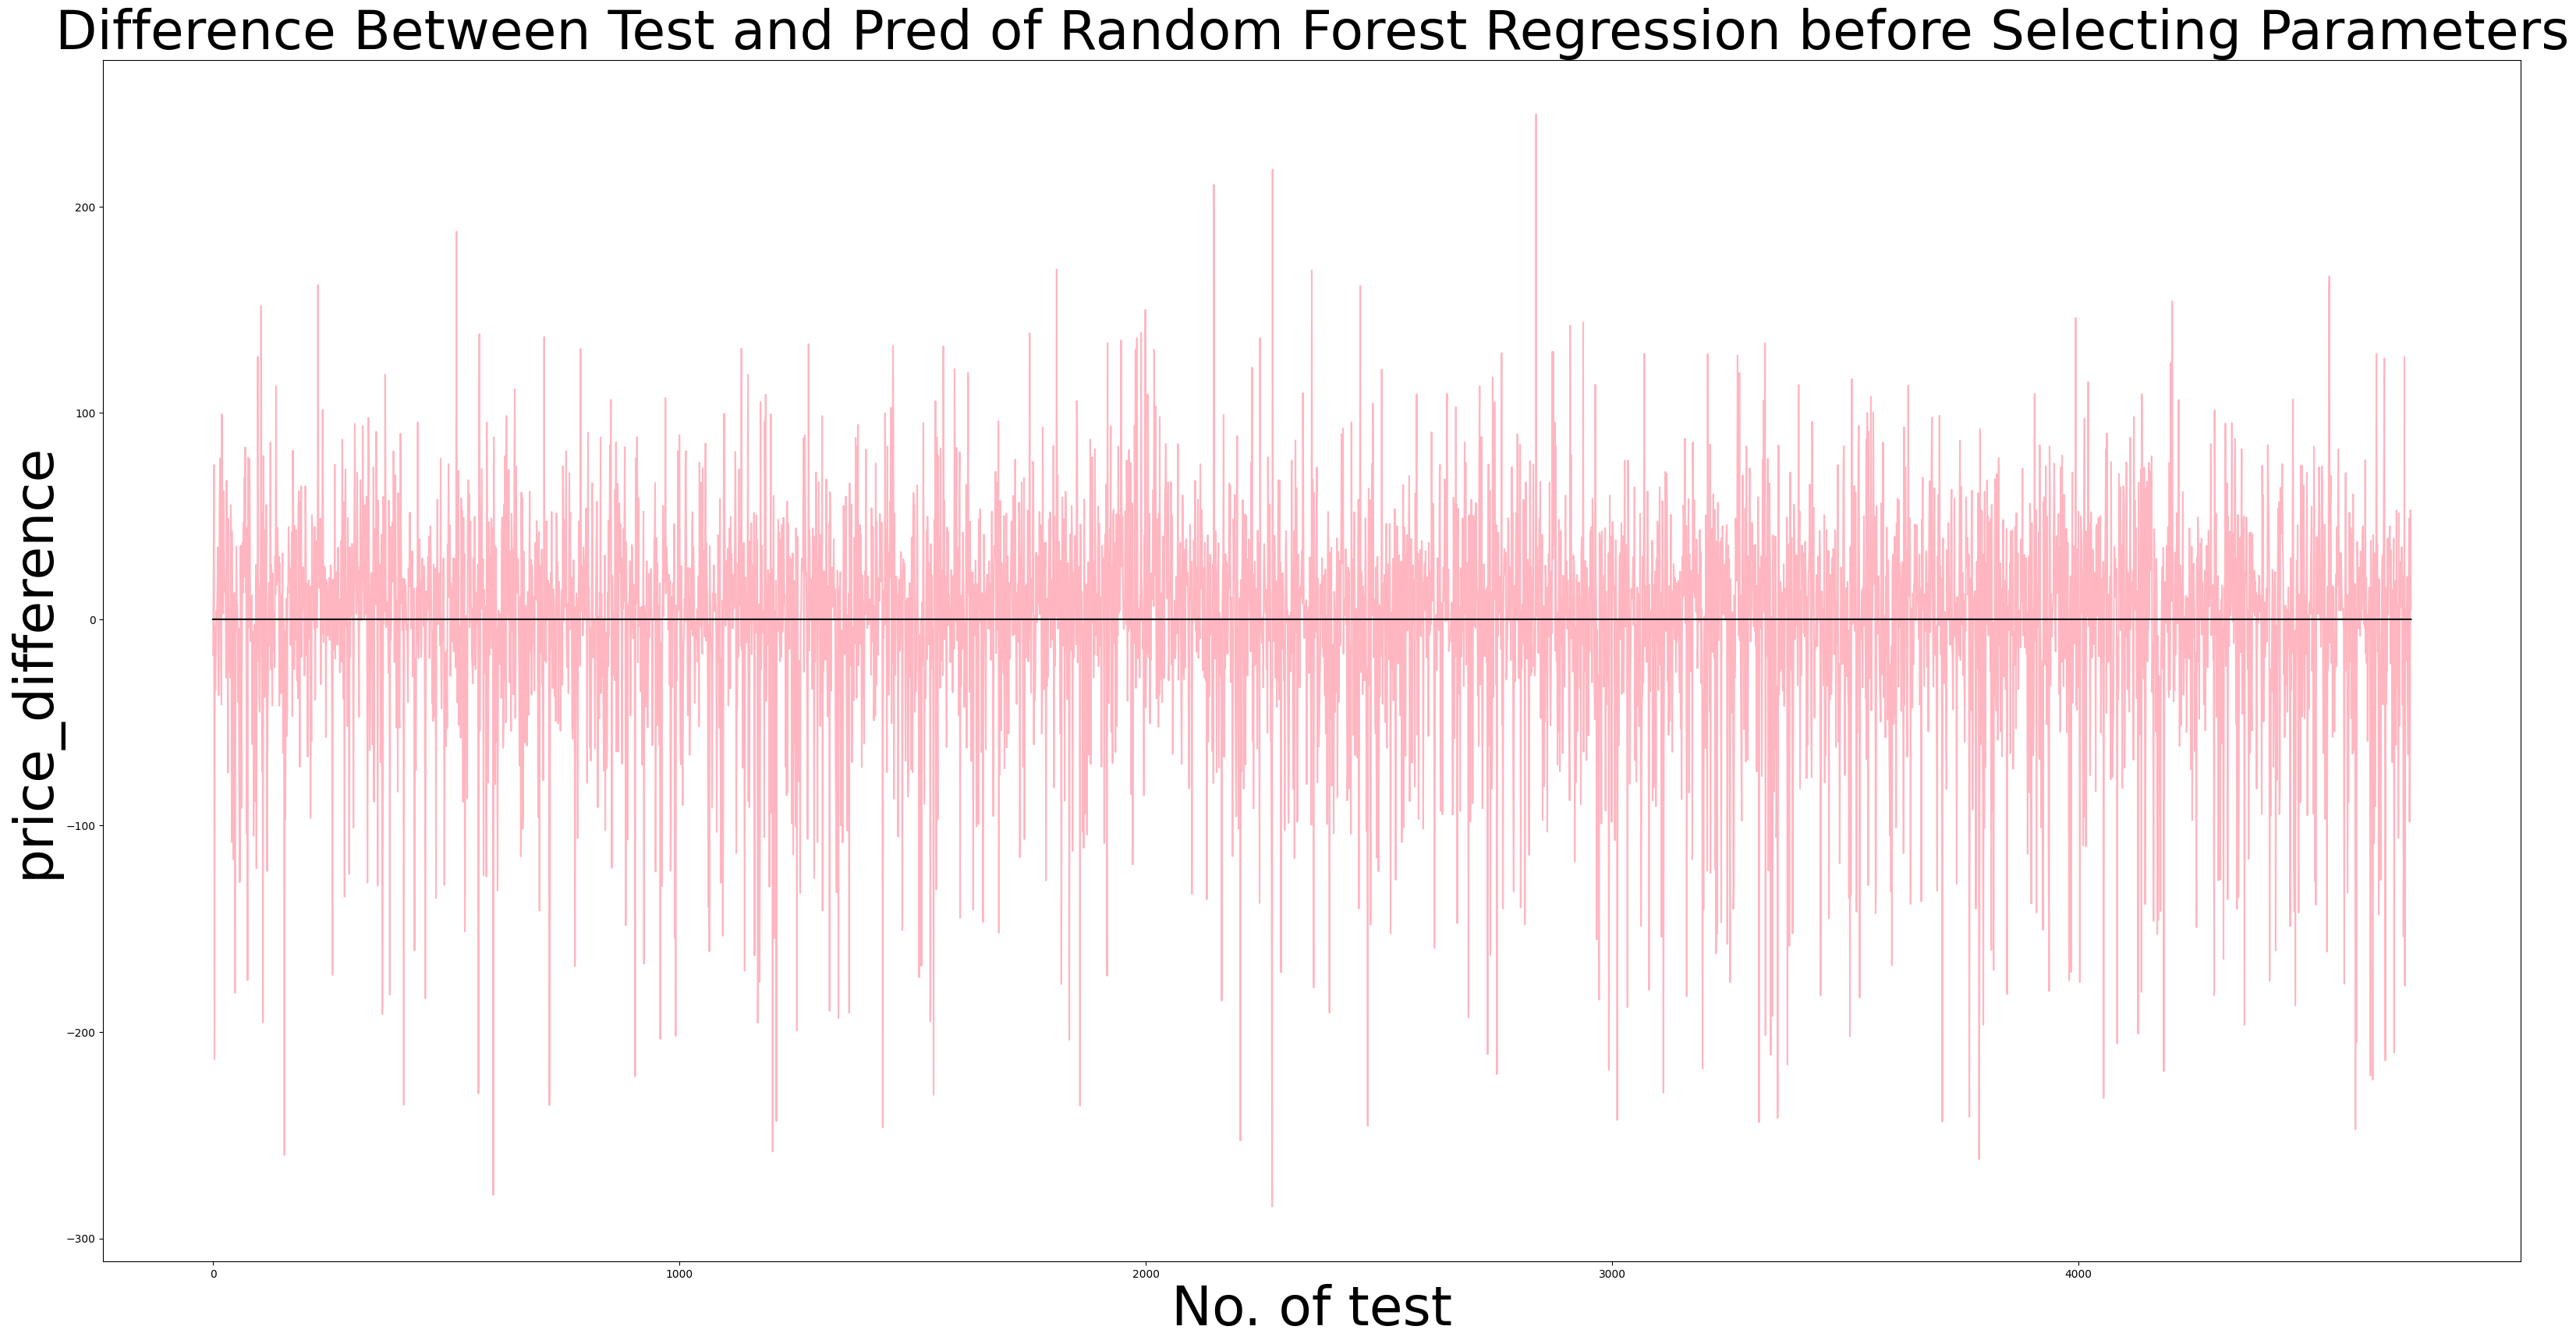

In [81]:
# Difference between test and pred
test_predrf = pd.DataFrame(y_test)
test_predrf['esti_price'] = y_predrf

plt.figure(figsize = (40,20))
plt.plot(range(len(y_predrf)),y_predrf-y_test1,'lightpink')
plt.plot(range(len(y_predrf)),np.zeros(4714),'black')
plt.ylim = (-300,200)
plt.title('Difference Between Test and Pred of Random Forest Regression before Selecting Parameters',fontsize = 50)
plt.xlabel('No. of test',fontsize = 50)
plt.ylabel('price_difference',fontsize = 50)
plt.savefig(r'D:\硕士\2023-2024 S2\COMP7103 Data mining\Project\result figure\difference_RF')

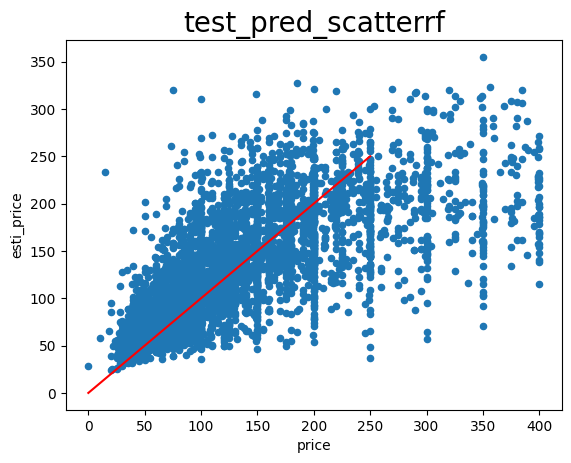

In [82]:
# estimated - actual price scatter plot
test_predrf.plot(x='price',y='esti_price',kind='scatter',fontsize = 10)
plt.title('test_pred_scatterrf',fontsize = 20)
x = np.linspace(0,250)
y=x
plt.plot(x,y,'r')
plt.savefig(r'D:\硕士\2023-2024 S2\COMP7103 Data mining\Project\result figure\difference_scatter_RF')

### Tuning Parameters - Random Search

#### Step1: Creating a Hyperparameter Grid

In [70]:
from sklearn.model_selection import RandomizedSearchCV

n_estimators = [int(x) for x in np.linspace(start = 200, stop = 1000, num = 5)]
max_features = ['auto', 'sqrt']
max_depth = [int(x) for x in np.linspace(10, 110, num = 6)]
max_depth.append(None)
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
bootstrap = [True, False]
rm_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
print(rm_grid)

{'n_estimators': [200, 400, 600, 800, 1000], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 30, 50, 70, 90, 110, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]}


#### Step2&3: 3-fold cross-validation with random search to find the corresponding parameters with the highest score

In [ ]:
# It will take hours to carry out  this validation

rf1 = RandomForestRegressor()

# 3-fold cross-validation
rf1_random = RandomizedSearchCV(estimator = rf1, param_distributions = rm_grid, n_iter = 180, cv = 3, verbose=2, random_state=42, n_jobs = -1)


rf1_random.fit(X_train1, y_train1)

print(rf2_random.best_params_) # best parametre

In [83]:
# rain a random forest model by using the optimal parameterst
regrf1 = RandomForestRegressor(n_estimators=400, max_depth = 110, min_samples_split = 10,min_samples_leaf =1,max_features = 'sqrt',bootstrap = True)
regrf1.fit(X_train1, y_train1)

RandomForestRegressor(max_depth=110, max_features='sqrt', min_samples_split=10,
                      n_estimators=400)

In [84]:
# R² decreased and risk of overfitting declined
print('R² = ',regrf1.score(X_train1, y_train1).round(3))

R² =  0.737


room_type_Private room            0.320
availability_365                  0.091
reviews_per_month                 0.075
calculated_host_listings_count    0.063
neighbourhood_group_Manhattan     0.062
                                  ...  
neighbourhood_Rossville           0.000
neighbourhood_Westerleigh         0.000
neighbourhood_Todt Hill           0.000
neighbourhood_Co-op City          0.000
neighbourhood_Silver Lake         0.000
Length: 229, dtype: float64


Text(0.5, 0, 'Relative Importance1')

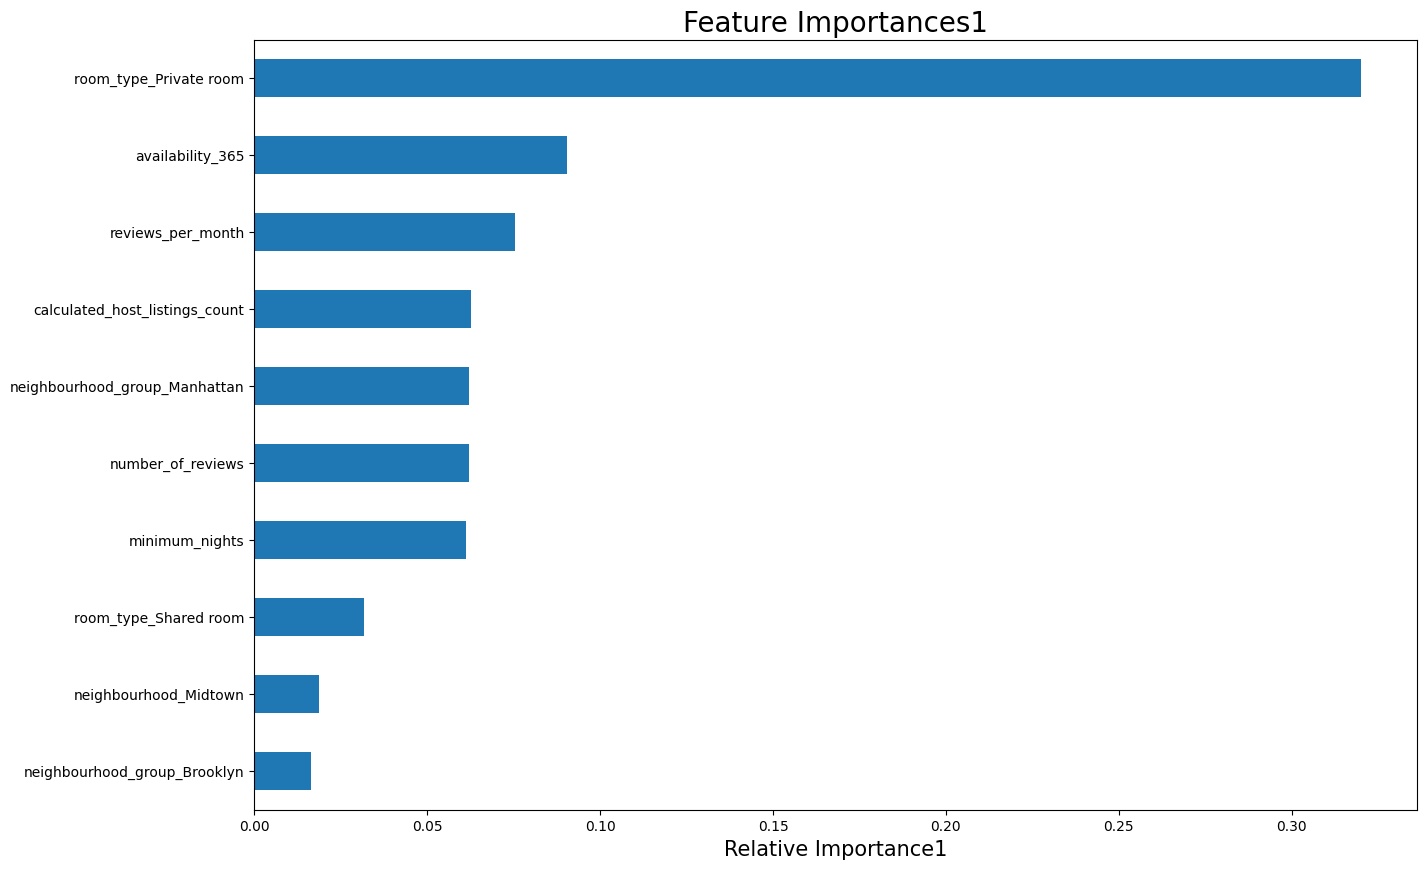

In [85]:
# feature importance again
importances1 = regrf1.feature_importances_
weights1 = pd.Series(importances1,
                 index=X_train1.columns.values)
print(weights1.sort_values(ascending = False).round(3))

plt.figure(figsize=(15,10))
plt.title('Feature Importances1',fontsize = 20)
weights1.sort_values()[-10:].plot(kind = 'barh')
plt.xlabel('Relative Importance1',fontsize = 15)

In [86]:
y_predrf1 = regrf1.predict(X_test1)
print('RMSE = ',np.sqrt(metrics.mean_squared_error(y_test1,y_predrf1)).round(3))

RMSE =  54.121


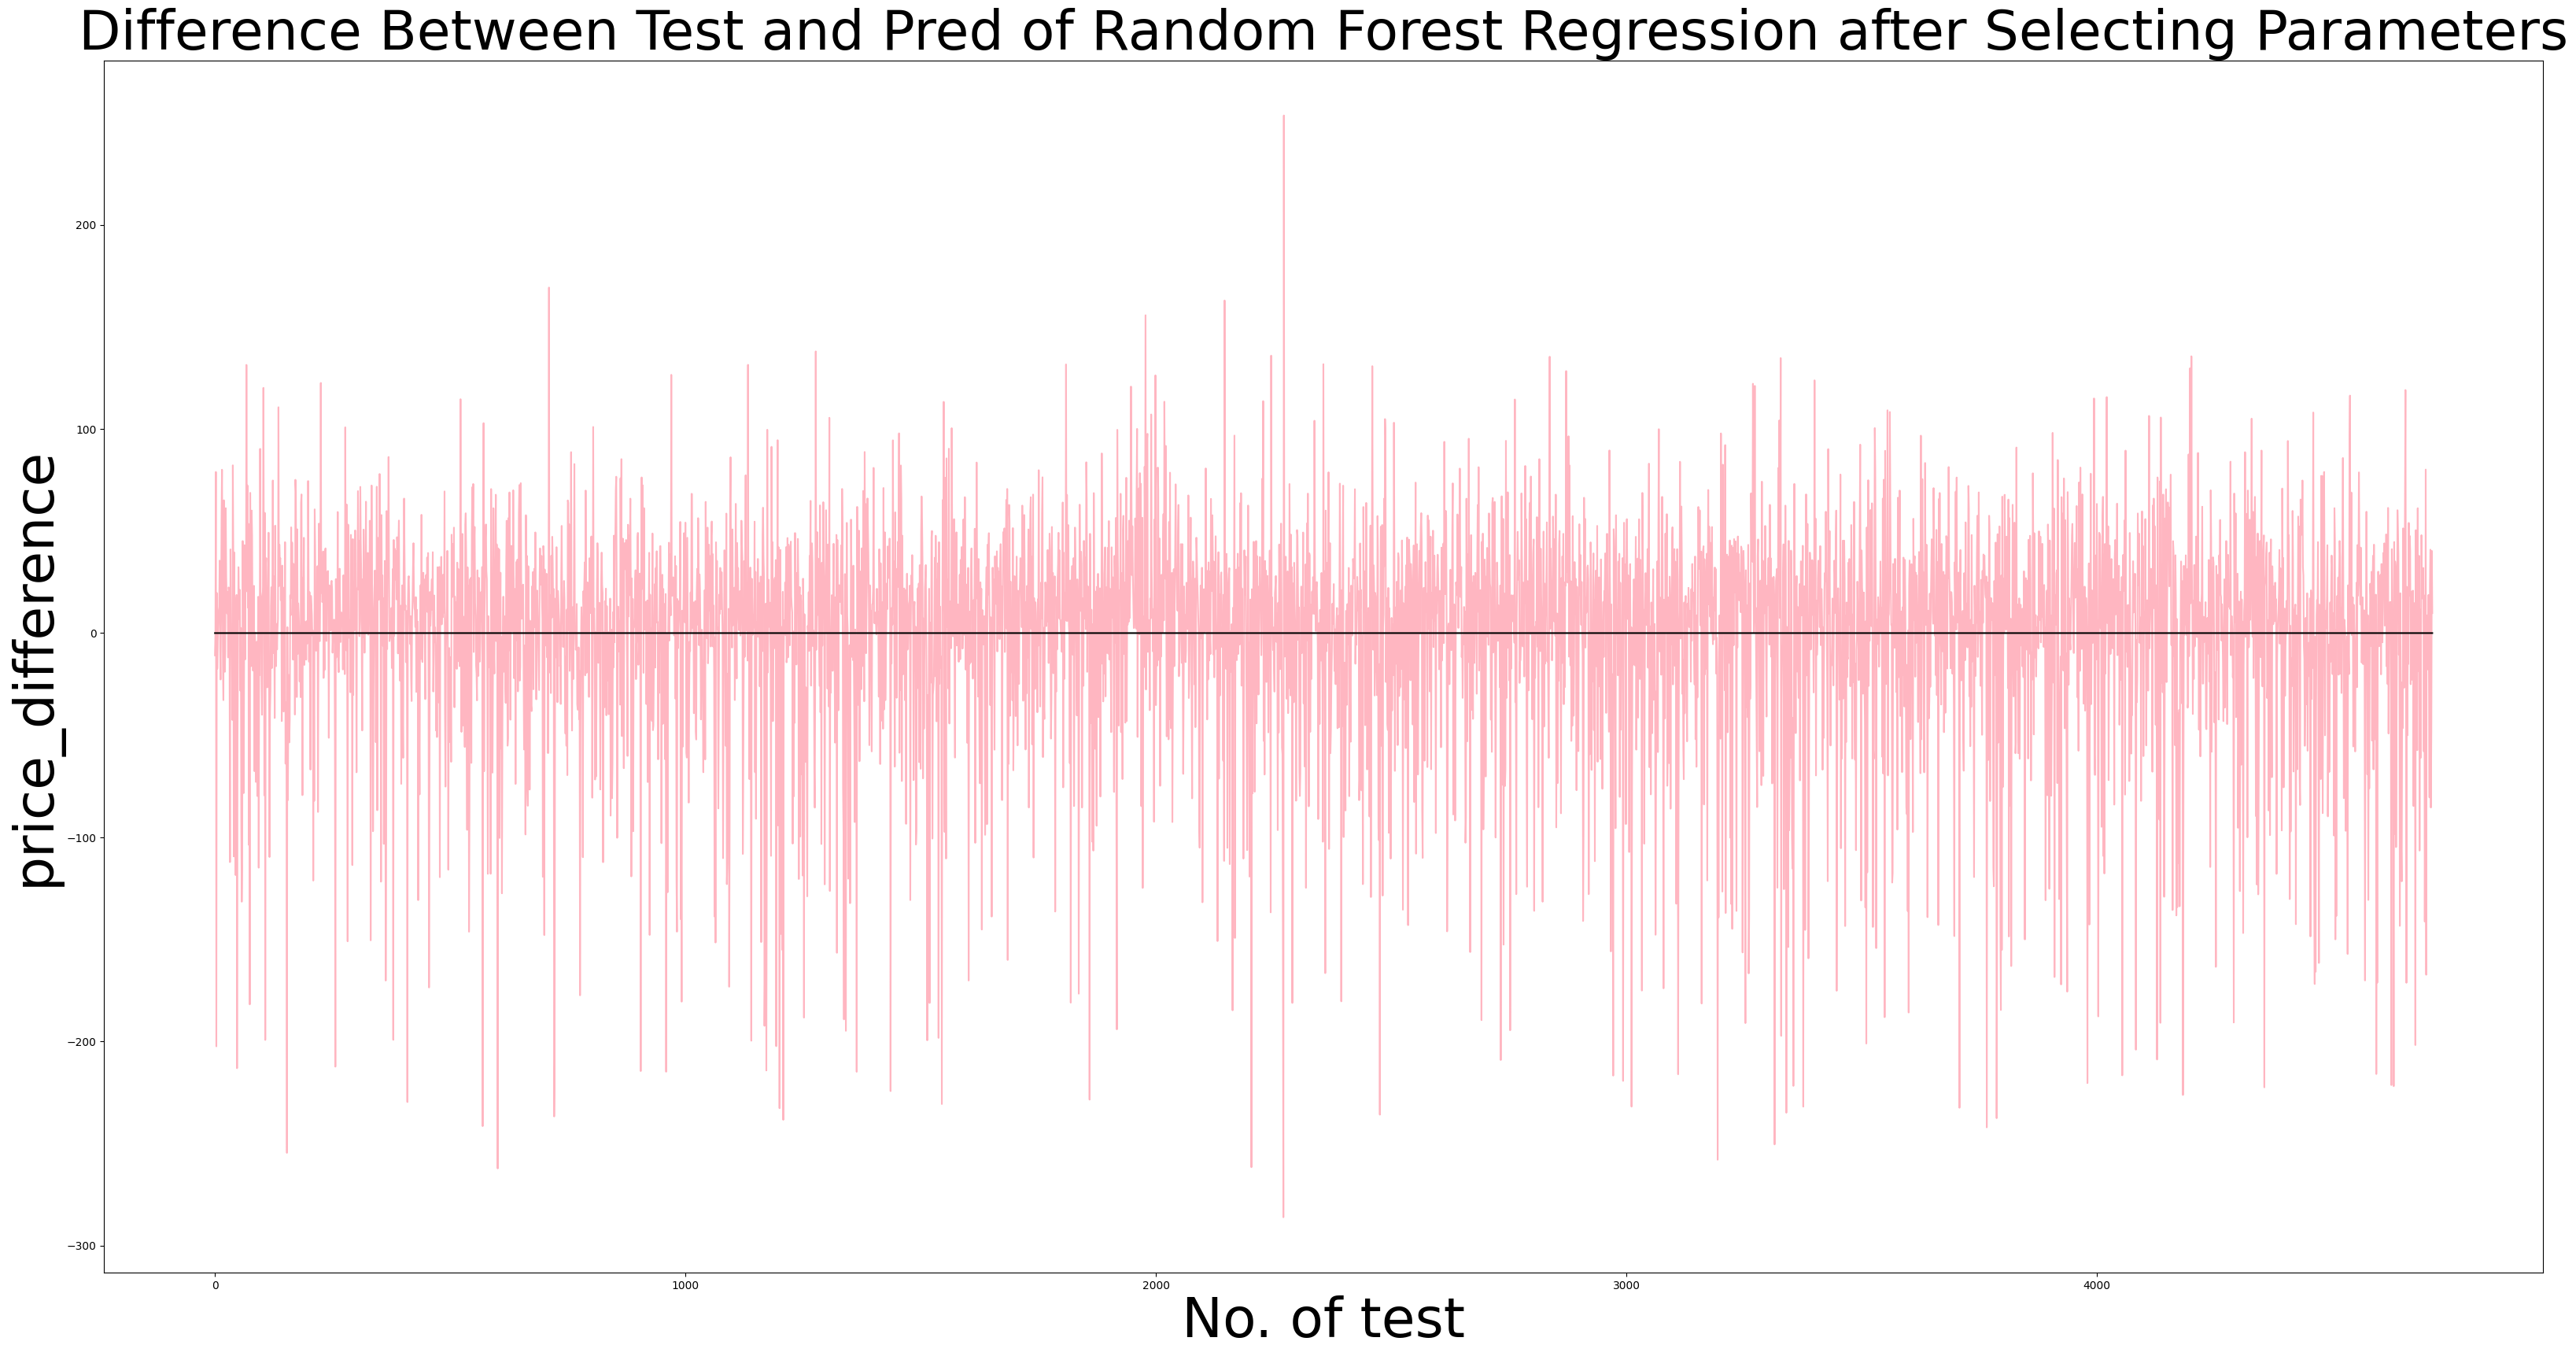

In [87]:
# Difference between test and pred
plt.figure(figsize = (40,20))
plt.plot(range(len(y_predrf1)),y_predrf1-y_test1,'lightpink')
plt.plot(range(len(y_predrf1)),np.zeros(4714),'black')
plt.ylim = (-300,200)
plt.title('Difference Between Test and Pred of Random Forest Regression after Selecting Parameters',fontsize = 50)
plt.xlabel('No. of test',fontsize = 50)
plt.ylabel('price_difference',fontsize = 50)
plt.savefig(r'D:\硕士\2023-2024 S2\COMP7103 Data mining\Project\result figure\difference_RF1')

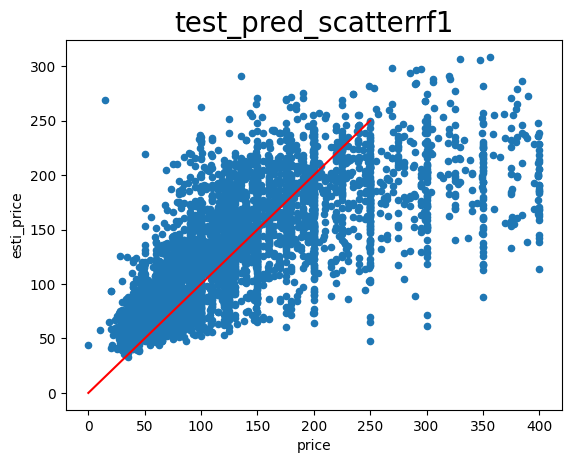

In [88]:
# estimated - actual price scatter plot
test_predrf1 = pd.DataFrame(y_test)
test_predrf1['esti_price'] = y_predrf1

test_predrf1.plot(x='price',y='esti_price',kind='scatter',fontsize = 10)
plt.title('test_pred_scatterrf1',fontsize = 20)
x = np.linspace(0,250)
y=x
plt.plot(x,y,'r')
plt.savefig(r'D:\硕士\2023-2024 S2\COMP7103 Data mining\Project\result figure\difference_scatter_RF1')

### (4) Neural Network

In [98]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.metrics import mean_squared_error, r2_score
# primary
model = keras.Sequential([
    layers.Dense(200, activation='relu', input_shape=[229]),
    layers.Dense(200, activation='relu'),
    layers.Dense(1)
])

model.compile(loss='mean_squared_error', optimizer=tf.keras.optimizers.Adam(0.0001))

history = model.fit(X_train1, y_train1, validation_split=0.1, epochs= 200, batch_size=64)

loss = model.evaluate(X_test1, y_test1)


y_pred1 = model.predict(X_test1)
y_pred1 = y_pred1.flatten()
RMSE = np.sqrt(mean_squared_error(y_test1, y_pred1))
r2 = r2_score(y_test1, y_pred1)
print ('RMSE = %.3f'%RMSE) 
print ('R² = %.3f'%r2) 

Epoch 1/200
597/597 [==============================] - 2s 3ms/step - loss: 13024.5811 - val_loss: 11469.2607
Epoch 2/200
597/597 [==============================] - 2s 3ms/step - loss: 9905.7412 - val_loss: 9015.9150
Epoch 3/200
597/597 [==============================] - 2s 3ms/step - loss: 7641.0337 - val_loss: 6737.7153
Epoch 4/200
597/597 [==============================] - 2s 3ms/step - loss: 5568.1641 - val_loss: 4940.5786
Epoch 5/200
597/597 [==============================] - 2s 3ms/step - loss: 4207.7061 - val_loss: 4134.3706
Epoch 6/200
597/597 [==============================] - 2s 3ms/step - loss: 3558.9346 - val_loss: 3565.7434
Epoch 7/200
597/597 [==============================] - 2s 3ms/step - loss: 3252.6367 - val_loss: 3392.4143
Epoch 8/200
597/597 [==============================] - 2s 3ms/step - loss: 3120.1694 - val_loss: 3351.1675
Epoch 9/200
597/597 [==============================] - 2s 3ms/step - loss: 3041.4790 - val_loss: 3272.5356
Epoch 10/200
597/597 [=============

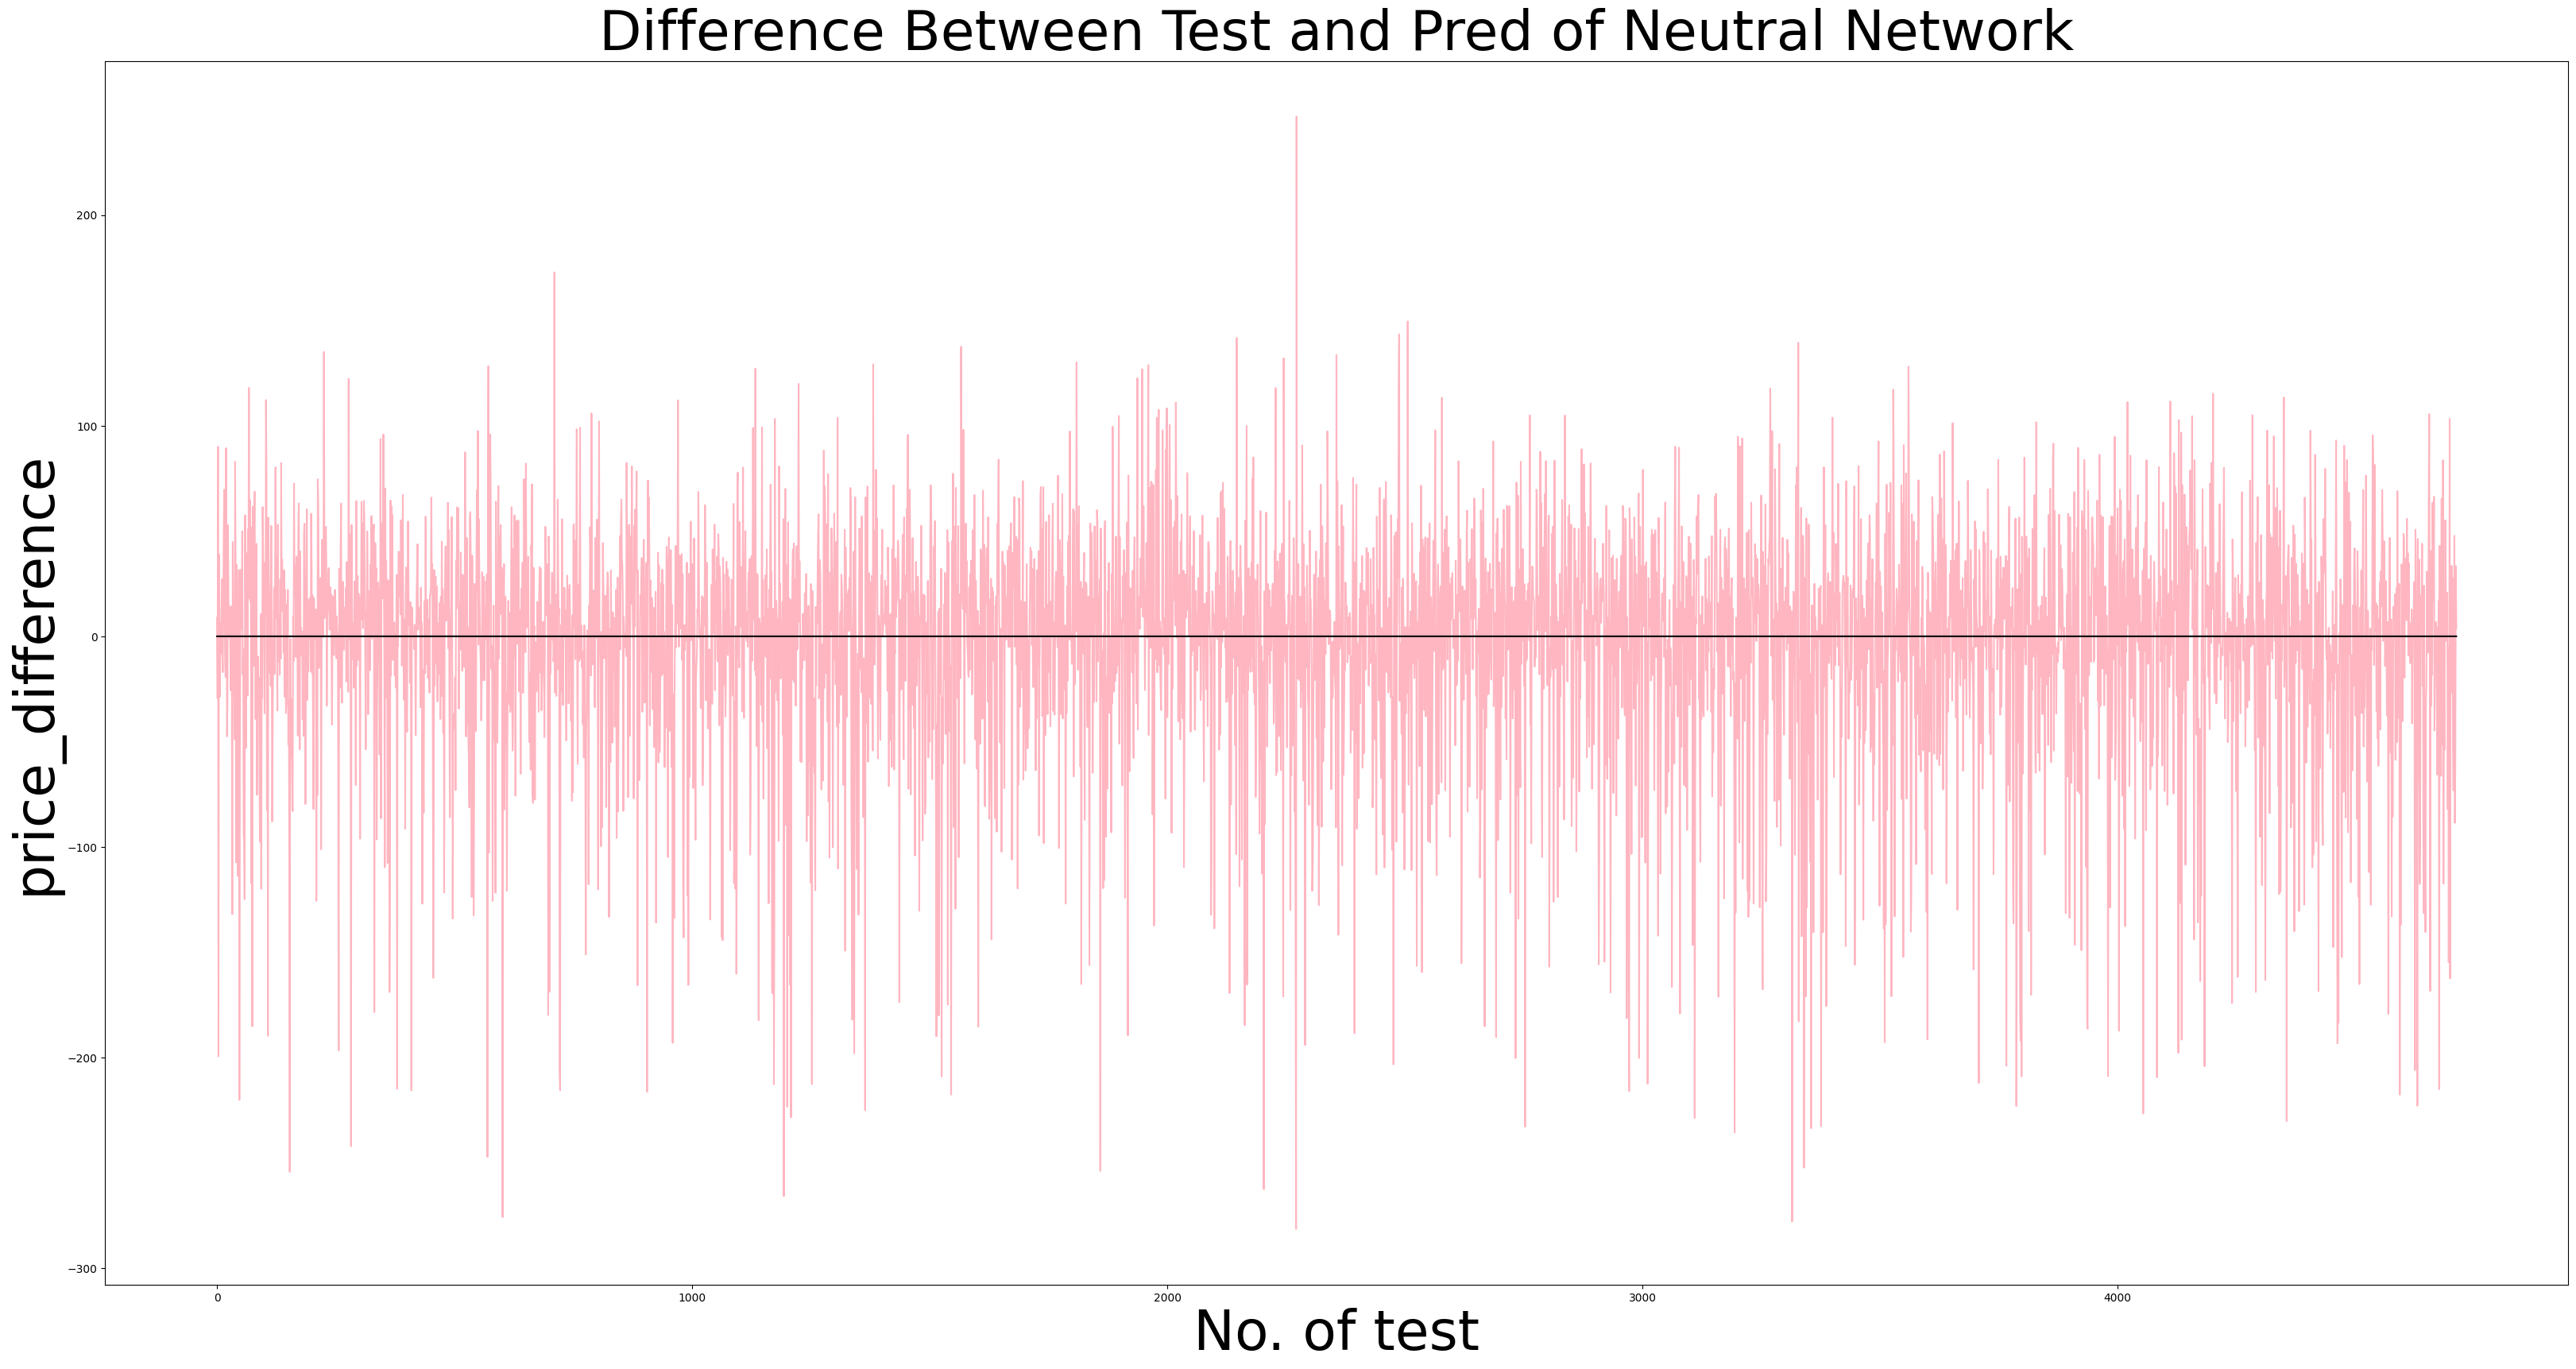

In [99]:
# Difference between test and pred
plt.figure(figsize = (40,20))
plt.plot(range(len(y_pred1)),y_pred1-y_test1,'lightpink')
plt.plot(range(len(y_pred1)),np.zeros(4714),'black')
plt.ylim = (-300,200)
plt.title('Difference Between Test and Pred of Neutral Network',fontsize = 50)
plt.xlabel('No. of test',fontsize = 50)
plt.ylabel('price_difference',fontsize = 50)
plt.savefig(r'D:\硕士\2023-2024 S2\COMP7103 Data mining\Project\result figure\difference_NN')

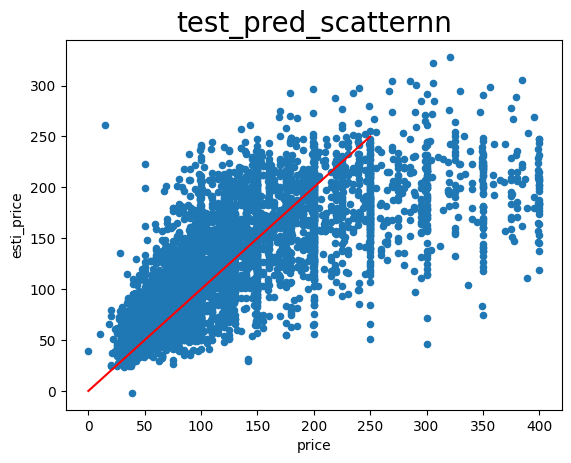

In [100]:
# estimated - actual price scatter plot
test_prednn = pd.DataFrame(y_test)
test_prednn['esti_price'] = y_pred1

test_prednn.plot(x='price',y='esti_price',kind='scatter',fontsize = 10)
plt.title('test_pred_scatternn',fontsize = 20)
x = np.linspace(0,250)
y=x
plt.plot(x,y,'r')
plt.savefig(r'D:\硕士\2023-2024 S2\COMP7103 Data mining\Project\result figure\difference_scatter_NN')

In [103]:
# L2 regularization
model = keras.Sequential([
    layers.Dense(200, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001), input_shape=[229]),
    layers.Dense(200, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    layers.Dense(1)
])

model.compile(loss='mean_squared_error', optimizer=tf.keras.optimizers.Adam(0.0001))

history = model.fit(X_train1, y_train1, validation_split=0.1, epochs=200, batch_size=64)

loss = model.evaluate(X_test1, y_test1)


y_pred1 = model.predict(X_test1)
y_pred1 = y_pred.flatten()
RMSE = np.sqrt(mean_squared_error(y_test1, y_pred1))
r2 = r2_score(y_test1, y_pred1)
print ('RMSE = %.3f'%RMSE) 
print ('R² = %.3f'%r2) 

Epoch 1/200
597/597 [==============================] - 3s 3ms/step - loss: 12835.1074 - val_loss: 11072.9209
Epoch 2/200
597/597 [==============================] - 2s 3ms/step - loss: 9558.8711 - val_loss: 8721.0957
Epoch 3/200
597/597 [==============================] - 2s 3ms/step - loss: 7288.9897 - val_loss: 6356.1250
Epoch 4/200
597/597 [==============================] - 2s 3ms/step - loss: 5247.1011 - val_loss: 4662.3257
Epoch 5/200
597/597 [==============================] - 2s 3ms/step - loss: 3989.7192 - val_loss: 3842.9231
Epoch 6/200
597/597 [==============================] - 2s 3ms/step - loss: 3411.8967 - val_loss: 3596.0911
Epoch 7/200
597/597 [==============================] - 2s 3ms/step - loss: 3181.6816 - val_loss: 3351.4578
Epoch 8/200
597/597 [==============================] - 2s 3ms/step - loss: 3086.4265 - val_loss: 3325.3147
Epoch 9/200
597/597 [==============================] - 2s 3ms/step - loss: 3032.3647 - val_loss: 3249.6587
Epoch 10/200
597/597 [=============

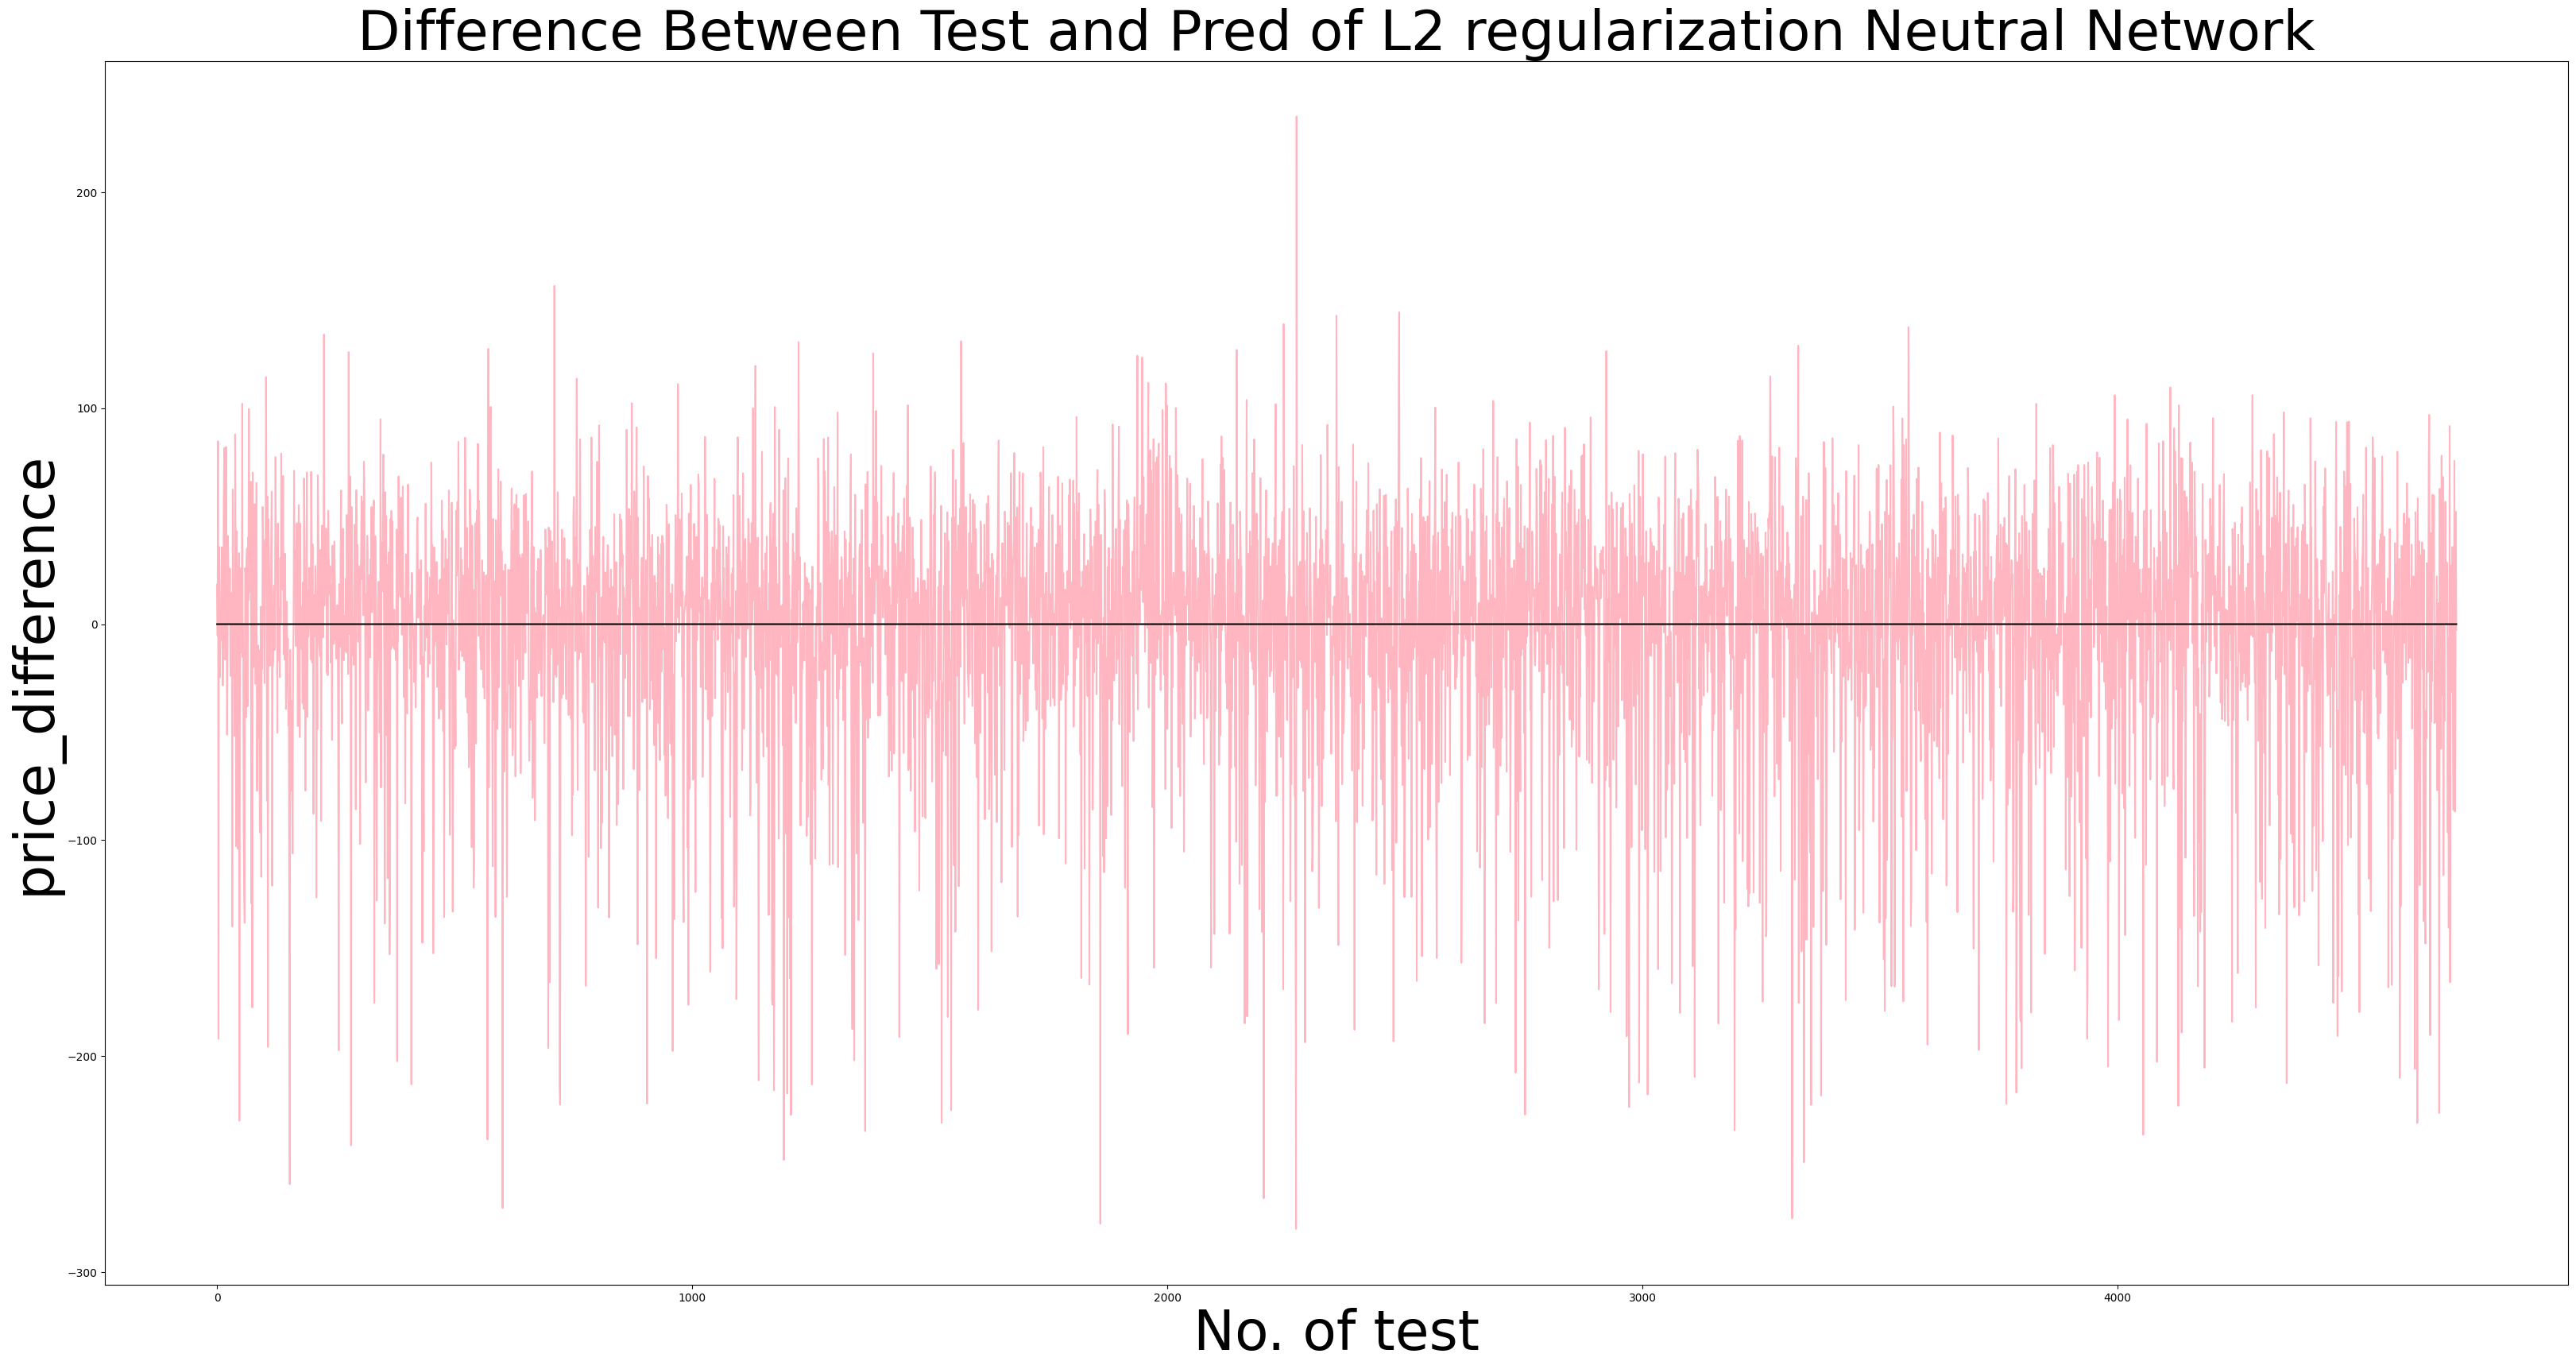

In [104]:
# Difference between test and pred
plt.figure(figsize = (40,20))
plt.plot(range(len(y_pred)),y_pred-y_test1,'lightpink')
plt.plot(range(len(y_pred)),np.zeros(4714),'black')
plt.ylim = (-300,200)
plt.title('Difference Between Test and Pred of L2 regularization Neutral Network',fontsize = 50)
plt.xlabel('No. of test',fontsize = 50)
plt.ylabel('price_difference',fontsize = 50)
plt.savefig(r'D:\硕士\2023-2024 S2\COMP7103 Data mining\Project\result figure\difference_NN1')

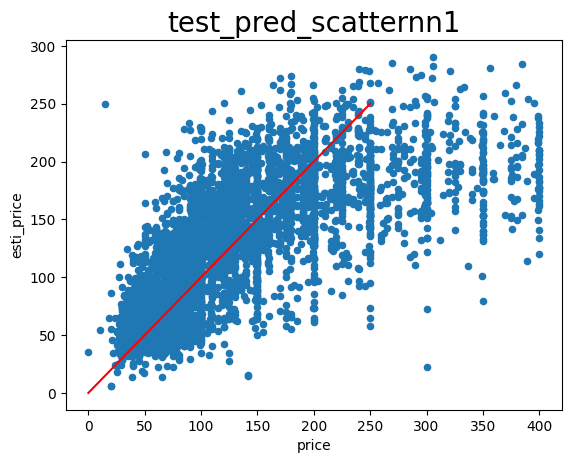

In [105]:
# estimated - actual price scatter plot
test_prednn1 = pd.DataFrame(y_test1)
test_prednn1['esti_price'] = y_pred1

test_prednn1.plot(x='price',y='esti_price',kind='scatter',fontsize = 10)
plt.title('test_pred_scatternn1',fontsize = 20)
x = np.linspace(0,250)
y=x
plt.plot(x,y,'r')
plt.savefig(r'D:\硕士\2023-2024 S2\COMP7103 Data mining\Project\result figure\difference_scatter_NN1')